# Recognizing digits and numbers in natural scene images
## Part 3: Deep Learning models for SVHN datasets

In [200]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import random
import pandas as pd

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### Load train, validation, and test datasets from pickle files

In [2]:
def load_pickle(pickle_file):
    """
    This will load a pickle file with 'images' and 'labels' datasets into two arrays
    """
    try:
        with open(pickle_file, 'rb') as f:
            if sys.version_info.major == 2:
                ds_combined = pickle.load(f)
            else:
                ds_combined = pickle.load(f, encoding='latin1') 
            ds_images = ds_combined["images"]
            ds_labels = ds_combined["labels"]
            f.close()
            print("Finish to load '%s' file" % pickle_file)
    except Exception as e:
        print('Unable to process data from', pickle_file, ':', e)
        raise
    return ds_images, ds_labels

In [3]:
train_dataset, train_labels = load_pickle('train_SVHN.pickle')
print("Train dataset shape:", train_dataset.shape, "Train labels shape:", train_labels.shape)

Finish to load 'train_SVHN.pickle' file
Train dataset shape: (32522, 32, 32) Train labels shape: (32522, 5)


In [4]:
valid_dataset, valid_labels = load_pickle('valid_SVHN.pickle')
print("Validation dataset shape:", valid_dataset.shape, "Validaton labels shape:", valid_labels.shape) 

Finish to load 'valid_SVHN.pickle' file
Validation dataset shape: (6968, 32, 32) Validaton labels shape: (6968, 5)


In [5]:
test_dataset, test_labels = load_pickle('test_SVHN.pickle')
print("Test dataset shape:", test_dataset.shape, "Test labels shape:", test_labels.shape)

Finish to load 'test_SVHN.pickle' file
Test dataset shape: (6968, 32, 32) Test labels shape: (6968, 5)


### Reformat into a TensorFlow-friendly shape:

* convolutions need the image data formatted as a cube (width by height by #channels)
* number of channels is 1 for grayscale
* remove the first column in labels

In [6]:
image_size = 32
num_channels = 1 # grayscale
num_digits = train_labels.shape[1] - 1 # from earlier defined labels
num_labels = 11 # per one digit

def reformat(dataset, labels, num_digits=num_digits, num_labels=num_labels):
    """
    creates image dataset as an array[image_size, image_size, num_channels]
    chage labels as an array[digit 1, digit 2, digit 3, digit 4]
    """
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = labels[:,1:]
  
    return dataset, labels

In [7]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

In [8]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (32522, 32, 32, 1) (32522, 4)
Validation set (6968, 32, 32, 1) (6968, 4)
Test set (6968, 32, 32, 1) (6968, 4)


### Accuracy definitions:

Each number is represented as a sequence of four digits. Zeros mean no digit at this particular position, and 10 means 0, for example, 506 labeled as [5, 10, 6, 0] 
* single digit recognition accuracy: total accuratly recognized digits devided by total digits in the dataset (including empty digits)
* number recognition accuracy: total accuratly recognized numbers devided by total numbers in the dataset.

In [9]:
def accuracy_single(predictions, labels):
    """
    accuracy of a single digit predicton across a dataset
    """
    total_digits_true = np.sum(np.argmax(predictions, 2).T == labels)       
    return 100.0 * total_digits_true / (predictions.shape[0] * predictions.shape[1])

In [10]:
def accuracy_number(predictions, labels):
    """
    accuracy of the entire number prediction across a dataset
    """
    total_true = predictions.shape[1] - np.sum([1 for p_digit in np.argmax(predictions, 2).T == labels if False in p_digit])
    return 100.0 * total_true / predictions.shape[1]

### Model 1: 3 hidden layers with 75% dropouts at training with decaying learning rate

**Predicting number represented as sequence of difits in this number: number = (d1, d2, d3, d4)**
* Running time ratio of CPU/GPU: 7.64. I will use GPU for fast training.
* Two measures of accuracy: accuracy_single and accuracy_number

**Tune regularizaton parameter beta = [0.05, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005, 0.0001] in 10000 epochs training per beta**

In [25]:
# variables defined earlier
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 128
patch_size = 5
depth = [16, 32, 64]
num_hidden = 1024
betas = [0.05, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005, 0.0001] # L2 regularization constant for all layers
num_steps = 10001

# prepare dictionaries to save accuracy for each beta
train_accuracy_s = {}
valid_accuracy_s = {}
test_accuracy_s = {}
train_accuracy_n = {}
valid_accuracy_n = {}
test_accuracy_n = {}

for beta in betas:

 #########################################

    graph = tf.Graph()

    with graph.as_default():

        with tf.device('/gpu:1'):
        #with tf.device('/cpu:0'):
            # helper functions

            def layer_weights(dimentions):
                """
                this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
                """ 
                return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
            def layer_biases(value, dimentions):
                """
                this function return  tf.Variable(tf.constant(value, shape=dimentions))
                """
                return tf.Variable(tf.constant(value, shape=dimentions))

            # Input data.
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
            tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

            # Variables.
            # conv layers
            l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
            l1_b = layer_biases(0., [depth[0]])

            l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
            l2_b = layer_biases(1.0, [depth[1]])

            l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
            l3_b = layer_biases(1.0, [depth[2]])

            # fully connected flat layer
            l4_w = layer_weights([image_size // 8 * image_size // 8 * depth[2], num_hidden])
            l4_b = layer_biases(1.0, [num_hidden])

            # locally connected digit layers
            l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
            l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

            # Model.
            def model(data, train = True):
              print('data', data.get_shape().as_list())

              conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
              hidden = tf.nn.relu(conv + l1_b)
              print('hidden conv1', hidden.get_shape().as_list())

              pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
              print('pool 1', pool.get_shape().as_list())

              conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
              hidden = tf.nn.relu(conv + l2_b)
              print('hidden conv2', hidden.get_shape().as_list())

              pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
              print('pool 2', pool.get_shape().as_list())

              conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
              hidden = tf.nn.relu(conv + l3_b)
              print('hidden conv3', hidden.get_shape().as_list())

              pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
              print('pool 3', pool.get_shape().as_list())

              shape = pool.get_shape().as_list()
              print("shape before flatten", shape)
              reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
              print("reshape_pool", reshape.get_shape().as_list())

              hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
              if train:
                  hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
              print('hidden fuc1', hidden.get_shape().as_list())

              final = []
              for idx in range(num_digits):
                    final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                    print("output layer for digit", idx+1, final[idx].get_shape().as_list())
              return final

            # Training computation.
            print("====================================")
            print("Train ConvNet")
            logits = model(tf_train_dataset)

            reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) 
                                 + tf.nn.l2_loss(l3_w) + tf.nn.l2_loss(l4_w))

            loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                          tf_train_labels[:, idx])) + reg_hidden + 
                          beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

            loss_final = tf.add_n(loss_digit)

            # Optimizer.
            global_step = tf.Variable(0)  # count the number of steps taken.
            learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, .9)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

            # Predictions for the training, validation, and test data.
            def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
                """
                predicting labels base on the current model
                """
                predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
                predictions = tf.pack(predictions_tmp)
                shape = predictions.get_shape().as_list()
                return predictions

            train_prediction = predictions_tf(logits)
            print("Train predictions shape", train_prediction.get_shape().as_list())
            print("====================================")
            print("Valid ConvNet")
            valid_prediction = predictions_tf(model(tf_valid_dataset, False))
            print("Valid predictions shape", valid_prediction.get_shape().as_list())
            print("====================================")
            print("Test ConvNet")
            test_prediction = predictions_tf(model(tf_test_dataset, False))
            print("Test predictions shape", test_prediction.get_shape().as_list())

    # Start training

    train_accuracy_s_step_1 = {}
    valid_accuracy_s_step_1 = {}
    train_accuracy_n_step_1 = {}
    valid_accuracy_n_step_1 = {}

    start = time.time()

    with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
        if sys.version_info.major == 2:
            print("Initializing variables")
            tf.initialize_all_variables().run()
        elif sys.version_info.major == 3: 
            print("Initializing variables")
            tf.global_variables_initializer().run()
        else:
            print("I can't run it on this version of python")
        
        print("====================================")
        print("Initialized with batch size = %d and regularizaton beta = %f" % (batch_size, beta))
        
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]

            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
            end = time.time()
            if (step % 100 == 0):
              train_accuracy_s_step_1[step] = accuracy_single(predictions, batch_labels)    
              valid_accuracy_s_step_1[step] = accuracy_single(valid_prediction.eval(), valid_labels)
              train_accuracy_n_step_1[step] = accuracy_number(predictions, batch_labels)    
              valid_accuracy_n_step_1[step] = accuracy_number(valid_prediction.eval(), valid_labels)
              if (step % 500 == 0):
                  print("Learning rate: %f" % learning_rate.eval())
                  print('Minibatch loss at step %d: %f' % (step, l))

                  print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_step_1[step])
                  print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_step_1[step])

                  print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_step_1[step])  
                  print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_step_1[step])
        
        test_predictions_final = test_prediction.eval()
        print('Test single digit accuracy: %.1f%%' % accuracy_single(test_predictions_final, test_labels))
        print('Test whole number accuracy: %.1f%%' % accuracy_number(test_predictions_final, test_labels))
        
        train_accuracy_s[beta] = train_accuracy_s_step_1[step]
        valid_accuracy_s[beta] = train_accuracy_s_step_1[step]
        test_accuracy_s[beta] = accuracy_single(test_predictions_final, test_labels)
        train_accuracy_n[beta] = train_accuracy_n_step_1[step]
        valid_accuracy_n[beta] = valid_accuracy_n_step_1[step]
        test_accuracy_n[beta] = accuracy_number(test_predictions_final, test_labels)

    print("Total training time is %f" % (end - start))

Train ConvNet
data [128, 32, 32, 1]
hidden conv1 [128, 32, 32, 16]
pool 1 [128, 16, 16, 16]
hidden conv2 [128, 16, 16, 32]
pool 2 [128, 8, 8, 32]
hidden conv3 [128, 8, 8, 64]
pool 3 [128, 4, 4, 64]
shape before flatten [128, 4, 4, 64]
reshape_pool [128, 1024]
hidden fuc1 [128, 1024]
output layer for digit 1 [128, 11]
output layer for digit 2 [128, 11]
output layer for digit 3 [128, 11]
output layer for digit 4 [128, 11]
Train predictions shape [4, 128, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 16]
pool 1 [6968, 16, 16, 16]
hidden conv2 [6968, 16, 16, 32]
pool 2 [6968, 8, 8, 32]
hidden conv3 [6968, 8, 8, 64]
pool 3 [6968, 4, 4, 64]
shape before flatten [6968, 4, 4, 64]
reshape_pool [6968, 1024]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
Valid predictions shape [4, 6968, 11]
Test ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32,

### Plot train (last batch), validation, and test accuracy vs beta

In [49]:
def plot_betas(train_acc, valid_acc, test_acc, name):
    """
    plot train, validation and test accuracy vs betas
    input:
    dictionaries of train, valid, and test accuracies with beta as keys
    
    """
    betas = list(train_acc.keys())
    # create lists of accuracies
    train_accuracy_l = [train_acc[beta_tmp] for beta_tmp in sorted(betas)]
    valid_accuracy_l = [valid_acc[beta_tmp] for beta_tmp in sorted(betas)]
    test_accuracy_l = [test_acc[beta_tmp] for beta_tmp in sorted(betas)]
    
    # find best max accuracies for validation and test for single digit and the whole number
    max_valid_acc = max(valid_accuracy_l)
    best_beta_valid_acc = sorted(betas)[valid_accuracy_l.index(max_valid_acc)]
    max_test_acc = max(test_accuracy_l)
    best_beta_test_acc = sorted(betas)[test_accuracy_l.index(max_test_acc)]
    
    print("The best %s validaton accuracy of %.1f%% where achived using beta = %.5f" % 
          (name, max_valid_acc, best_beta_valid_acc))
    print("The best %s test accuracy of %.1f%% where achived using Beta = %.5f" % 
          (name, max_test_acc, best_beta_test_acc))
    
    plt.figure(figsize=(8,4))

    plt.semilogx(sorted(betas), train_accuracy_l, 'g*-', label='train accuracy')
    plt.semilogx(sorted(betas), valid_accuracy_l, 'rv--', label='validation accuracy')
    plt.semilogx(sorted(betas), test_accuracy_l, 'bo-', label='test accuracy')

    plt.legend(loc=0)
    plt.title("Tuning L2 regularization for "+name)
    plt.xlabel("beta")
    plt.ylabel(name+" accuracy, %")
    plt.xlim(0.1, 0.0001)
    #plt.ylim(75, 90)
    

The best single digit validaton accuracy of 87.5% where achived using beta = 0.00750
The best single digit test accuracy of 89.2% where achived using Beta = 0.00750


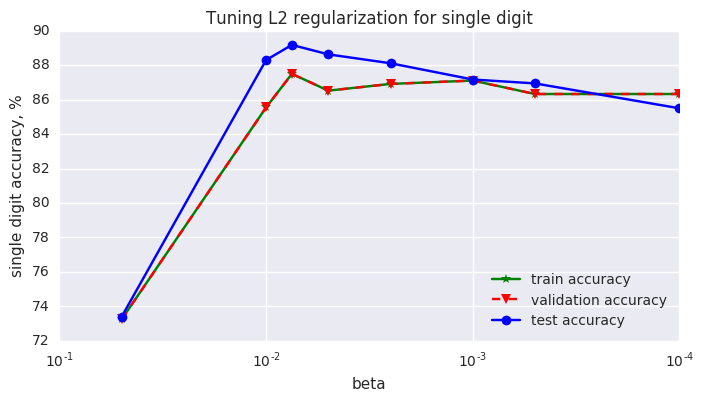

In [50]:
plot_betas(train_accuracy_s, valid_accuracy_s, test_accuracy_s, name="single digit")

The best whole number validaton accuracy of 68.2% where achived using beta = 0.00750
The best whole number test accuracy of 69.4% where achived using Beta = 0.00750


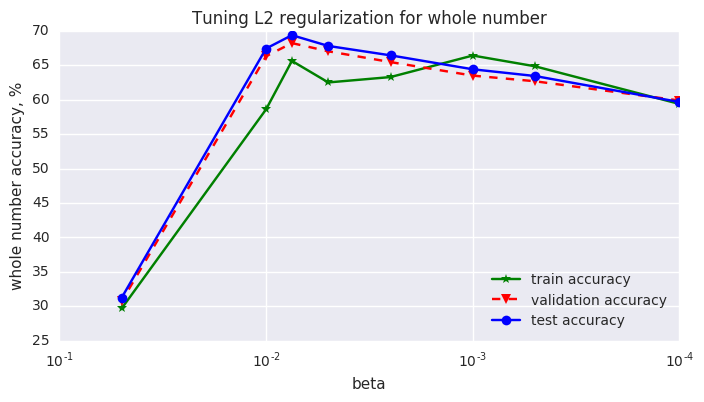

In [51]:
plot_betas(train_accuracy_n, valid_accuracy_n, test_accuracy_n, name="whole number")

In [ ]:
# chop training dataset to match it to batch size
train_dataset_n = train_dataset[:32256, :, :, :]
train_labels_n = train_labels[:32256, :]
print(train_dataset_n.shape)
print(train_labels_n.shape)

### We wil train this model with the beta 0.0075 and 50000 epochs.

In [555]:
# variables defined earlier
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 128
patch_size = 5
depth = [16, 32, 64]
num_hidden = 1024
beta = 0.0075

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 8 * image_size // 8 * depth[2], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) 
                             + tf.nn.l2_loss(l3_w) + tf.nn.l2_loss(l4_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, .9)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())


Train ConvNet
data [128, 32, 32, 1]
hidden conv1 [128, 32, 32, 16]
pool 1 [128, 16, 16, 16]
hidden conv2 [128, 16, 16, 32]
pool 2 [128, 8, 8, 32]
hidden conv3 [128, 8, 8, 64]
pool 3 [128, 4, 4, 64]
shape before flatten [128, 4, 4, 64]
reshape_pool [128, 1024]
hidden fuc1 [128, 1024]
output layer for digit 1 [128, 11]
output layer for digit 2 [128, 11]
output layer for digit 3 [128, 11]
output layer for digit 4 [128, 11]
Train predictions shape [4, 128, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 16]
pool 1 [6968, 16, 16, 16]
hidden conv2 [6968, 16, 16, 32]
pool 2 [6968, 8, 8, 32]
hidden conv3 [6968, 8, 8, 64]
pool 3 [6968, 4, 4, 64]
shape before flatten [6968, 4, 4, 64]
reshape_pool [6968, 1024]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
Valid predictions shape [4, 6968, 11]
Test ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32,

In [556]:
num_steps = 50001

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m1 = {}
valid_accuracy_s_m1 = {}
test_accuracy_s_m1 = {}
train_accuracy_n_m1 = {}
valid_accuracy_n_m1 = {}
test_accuracy_n_m1 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables")
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with batch size = %d and regularizaton beta = %f" % (batch_size, beta))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m1[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m1[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m1[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m1[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final = test_prediction.eval()
          test_accuracy_s_m1[step] = accuracy_single(test_predictions_final, test_labels)
          test_accuracy_n_m1[step] = accuracy_number(test_predictions_final, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m1[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m1[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m1[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m1[step])
    
    print('Besst Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m1.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m1.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m1.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m1.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m1.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m1.values()))

training_time_f_m1 = end - start
print("Total training time is %f" % training_time_f_m1)

Initializing variables
Initialized with batch size = 128 and regularizaton beta = 0.007500
Learning rate: 0.009999
Minibatch loss at step 0: 241.201721
Minibatch single digit accuracy: 17.6%
Minibatch whole number accuracy: 0.0%
Validation single digit accuracy: 47.3%
Validation whole number accuracy: 0.7%
Learning rate: 0.008999
Minibatch loss at step 1000: 77.807587
Minibatch single digit accuracy: 70.9%
Minibatch whole number accuracy: 21.9%
Validation single digit accuracy: 72.6%
Validation whole number accuracy: 29.1%
Learning rate: 0.008099
Minibatch loss at step 2000: 48.054783
Minibatch single digit accuracy: 76.0%
Minibatch whole number accuracy: 37.5%
Validation single digit accuracy: 79.5%
Validation whole number accuracy: 44.7%
Learning rate: 0.007289
Minibatch loss at step 3000: 30.908562
Minibatch single digit accuracy: 84.0%
Minibatch whole number accuracy: 53.9%
Validation single digit accuracy: 82.5%
Validation whole number accuracy: 52.1%
Learning rate: 0.006560
Minib

### Plot accuracies vs traning epochs

In [436]:
def plot_train_valid(train_dic, valid_dic, steps, name):
    """
    plot training-validation accuracy evolution
    """
    plt.figure(figsize=(8,4))
    x_tmp = [step_tmp for step_tmp in sorted(train_dic.keys()) if step_tmp <= steps]
    y_t_tmp = [train_dic[step_tmp] for step_tmp in x_tmp]
    y_v_tmp = [valid_dic[step_tmp] for step_tmp in x_tmp]
    
    plt.plot(x_tmp, y_t_tmp, 'go-', label='train accuracy')
    plt.plot(x_tmp, y_v_tmp, 'ro-', label='validation accuracy')
    plt.legend(loc=0)
    plt.title("Accuracy vs number of training epochs for %s \n max train accuracy is %.2f%% \n max validation accuracy is %.2f%%" % (name, max(y_t_tmp), max(y_v_tmp)))
    plt.xlabel('Steps')
    plt.ylabel(name+' accuracy')
    plt.xlim(0, max(x_tmp))
    #plt.ylim(0, 60)

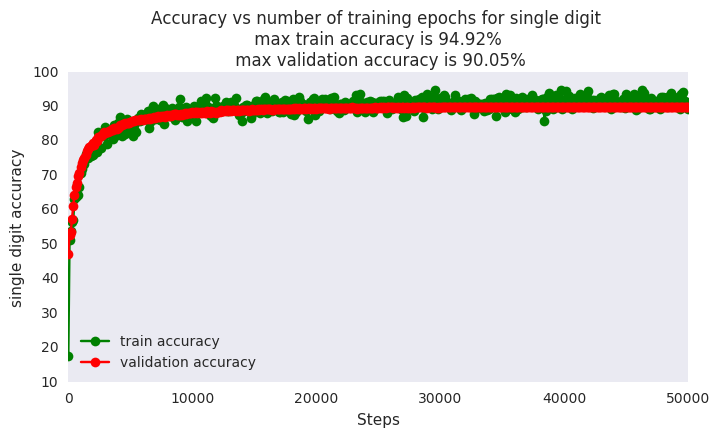

In [557]:
plot_train_valid(train_accuracy_s_m1, valid_accuracy_s_m1, 50000, 'single digit')

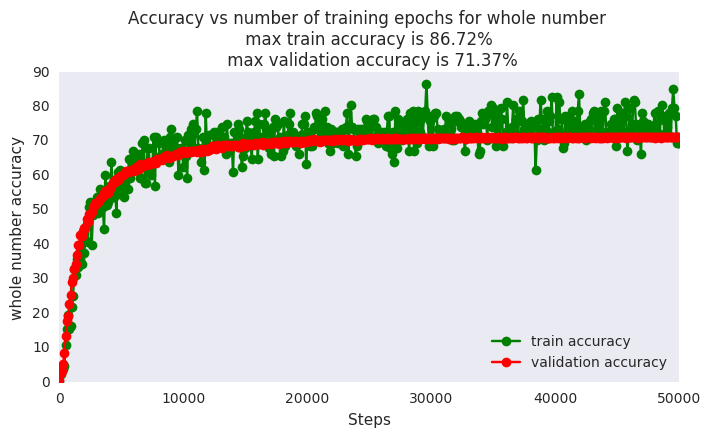

In [558]:
plot_train_valid(train_accuracy_n_m1, valid_accuracy_n_m1, 50000, 'whole number')

In [439]:
def image_show_ds(t_ds, t_l, predictions, correct=True):
    """
    This function shows three randomply picked up images with corectly defined labels from a dataset 
    if correct set to "True", and falsly predicted numbers if correct set to "False".
    Inputs are image dataset, corresponding labels dataset, and predictions array.
    """
    sns.set_style({'axes.grid' : False}) # get rid of grid
    title = ('Three randomly chosen images from the loaded dataset')
    fig = plt.figure(figsize=(18,5))
    
    all_idx = range(t_l.shape[0])
    idx = list((set(np.where((np.argmax(predictions, 2).T == test_labels) == False)[0])))
    if correct:
        idx = list(set(all_idx).difference(idx))
    idx_return = []
    counter = 1
    for image_idx_tmp in random.sample(idx, 3):
        fig.add_subplot(1, 3, counter)
        plt.imshow(t_ds[image_idx_tmp,:,:,0])
        plt.title("Labels: %s, Predictions: %s" % (t_l[image_idx_tmp], (np.argmax(predictions, 2).T)[image_idx_tmp]))
        idx_return.append(image_idx_tmp)
        counter += 1
    return idx_return

Properly predicted numbers examples


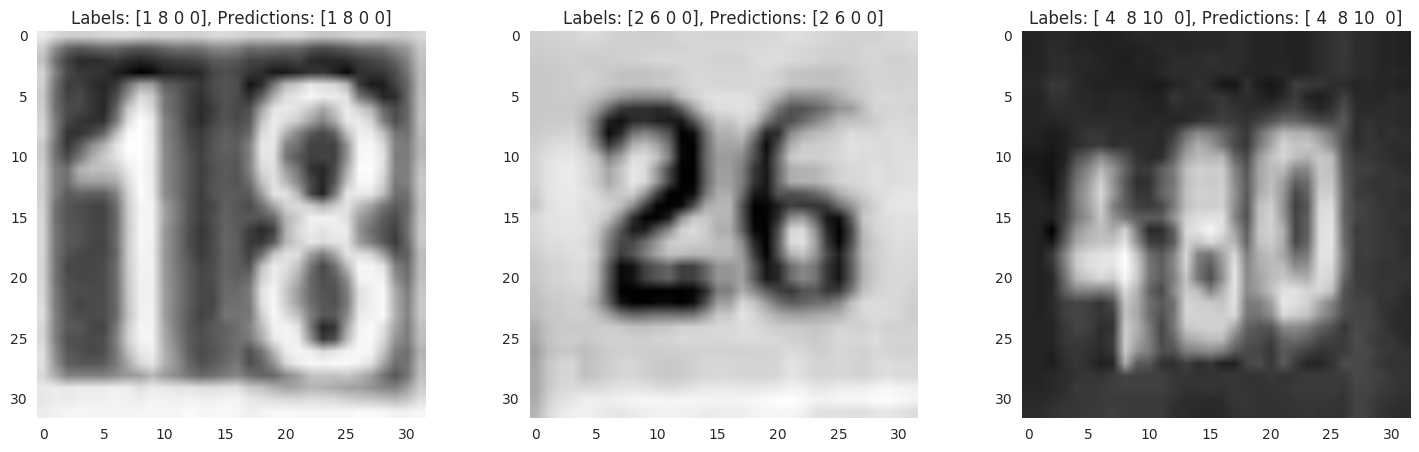

In [560]:
print("Properly predicted numbers examples")
model_1_image_idx_good = image_show_ds(test_dataset, test_labels, test_predictions_final, True)

Properly predicted numbers examples


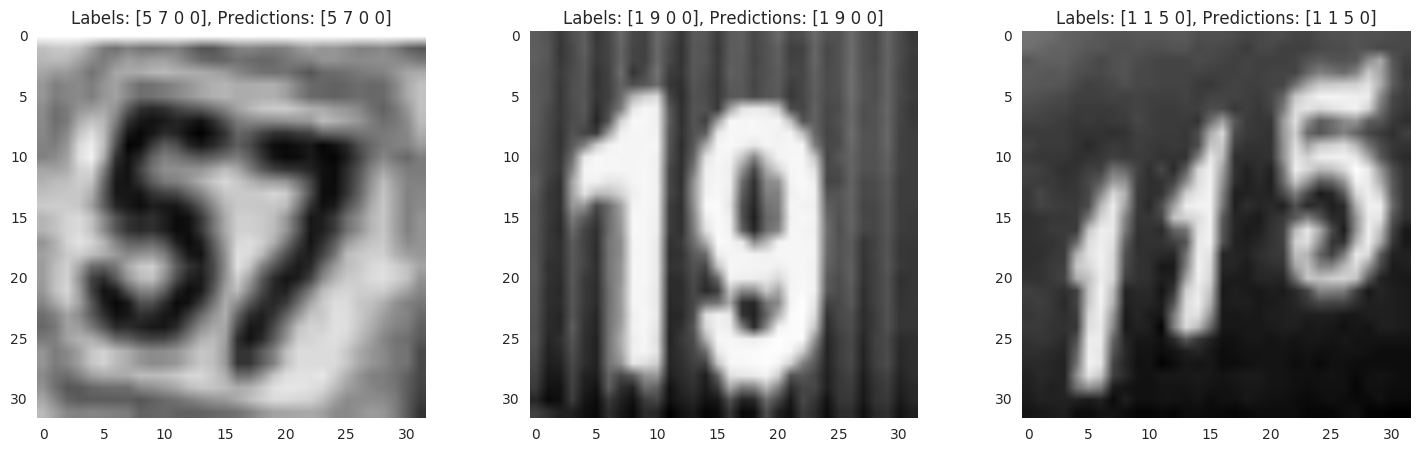

In [568]:
print("Properly predicted numbers examples")
model_1_image_idx_good_2 = image_show_ds(test_dataset, test_labels, test_predictions_final, True)

Falsely predicted numbers examples


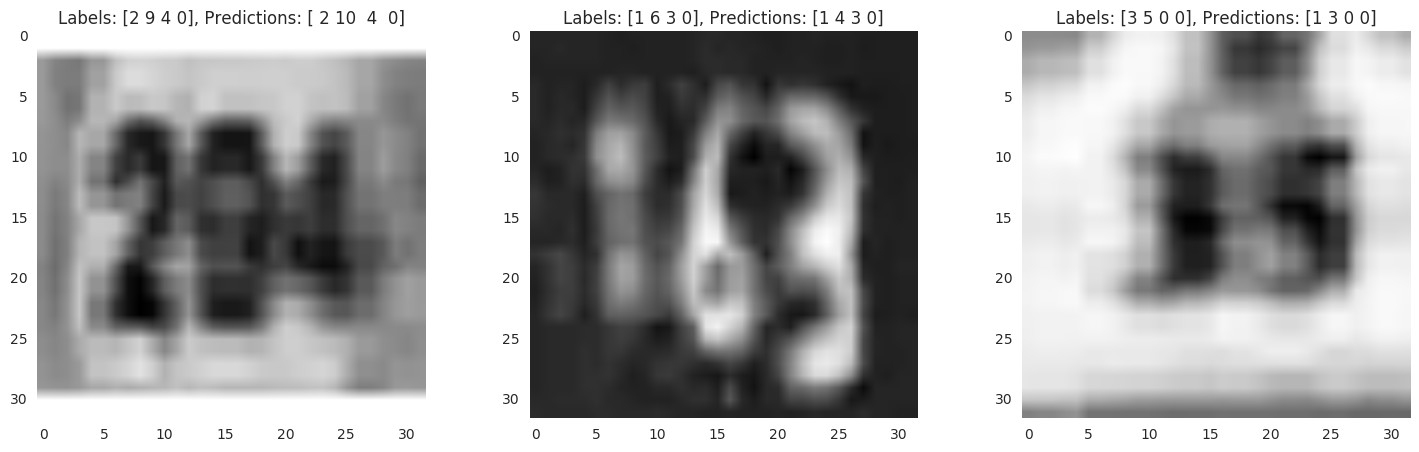

In [562]:
print("Falsely predicted numbers examples")
model_1_image_idx_bad = image_show_ds(test_dataset, test_labels, test_predictions_final, False)

Falsely predicted numbers examples


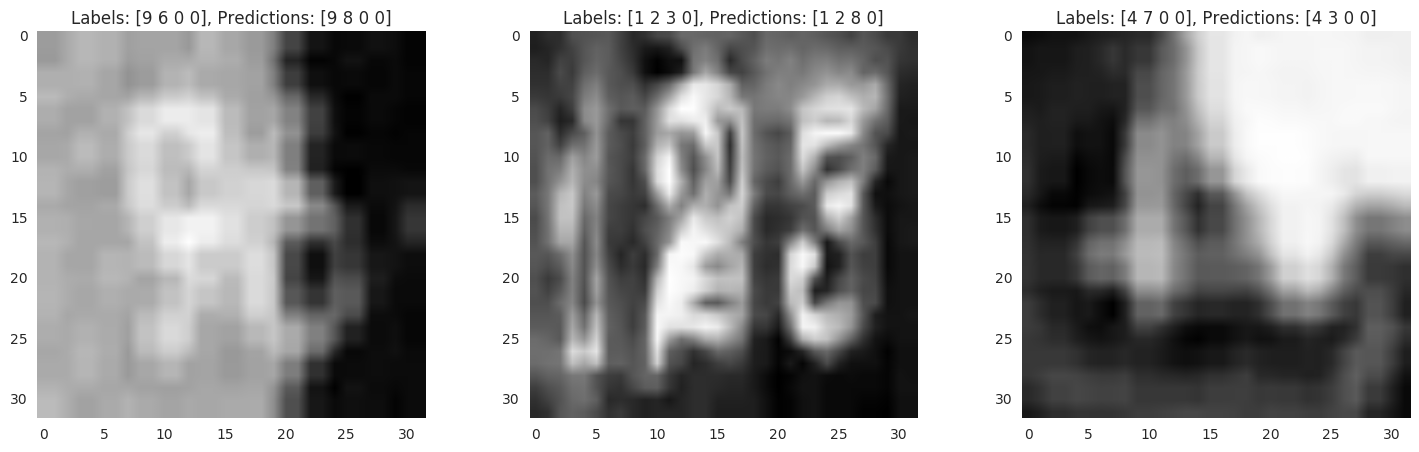

In [564]:
print("Falsely predicted numbers examples")
model_1_image_idx_bad_2 = image_show_ds(test_dataset, test_labels, test_predictions_final, False)

In [569]:
training_time_f_m1 = 1192.897617
print("Training time for Model 1 is %d min" % int(training_time_f_m1/60))

Training time for Model 1 is 19 min


### Results
#### Model 1
====================================<br />
Train ConvNet<br />
data [128, 32, 32, 1]<br />
hidden conv1 [128, 32, 32, 16]<br />
pool 1 [128, 16, 16, 16]<br />
hidden conv2 [128, 16, 16, 32]<br />
pool 2 [128, 8, 8, 32]<br />
hidden conv3 [128, 8, 8, 64]<br />
pool 3 [128, 4, 4, 64]<br />
reshape_pool [128, 1024]<br />
hidden fuc1 [128, 1024]<br />
output layer for digit 1 [128, 11]<br />
output layer for digit 2 [128, 11]<br />
output layer for digit 3 [128, 11]<br />
output layer for digit 4 [128, 11]<br />
====================================<br />

* **Best Minibatch single digit accuracy: 94.9%**
* **Best Minibatch whole number accuracy: 86.7%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.7%**

### Let's make this model more complex by adding one more fully connected layer (size 256)

In [444]:
# variables defined earlier
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 128
patch_size = 5
depth = [16, 32, 64]
num_hidden = 1024
num_hidden2 = 256
beta = 0.0075

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 8 * image_size // 8 * depth[2], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])
        
        # second fully connected flat layer
        l5_w = layer_weights([num_hidden, num_hidden2])
        l5_b = layer_biases(1.0, [num_hidden2])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden2, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(hidden, l5_w) + l5_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc2', hidden.get_shape().as_list())       
        
          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) 
                             + tf.nn.l2_loss(l3_w) + tf.nn.l2_loss(l4_w) + tf.nn.l2_loss(l5_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, .9)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())

Train ConvNet
data [128, 32, 32, 1]
hidden conv1 [128, 32, 32, 16]
pool 1 [128, 16, 16, 16]
hidden conv2 [128, 16, 16, 32]
pool 2 [128, 8, 8, 32]
hidden conv3 [128, 8, 8, 64]
pool 3 [128, 4, 4, 64]
shape before flatten [128, 4, 4, 64]
reshape_pool [128, 1024]
hidden fuc1 [128, 1024]
hidden fuc2 [128, 256]
output layer for digit 1 [128, 11]
output layer for digit 2 [128, 11]
output layer for digit 3 [128, 11]
output layer for digit 4 [128, 11]
Train predictions shape [4, 128, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 16]
pool 1 [6968, 16, 16, 16]
hidden conv2 [6968, 16, 16, 32]
pool 2 [6968, 8, 8, 32]
hidden conv3 [6968, 8, 8, 64]
pool 3 [6968, 4, 4, 64]
shape before flatten [6968, 4, 4, 64]
reshape_pool [6968, 1024]
hidden fuc1 [6968, 1024]
hidden fuc2 [6968, 256]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
Valid predictions shape [4, 6968, 11]
Test ConvNet
dat

In [447]:
num_steps = 50001

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m2 = {}
valid_accuracy_s_m2 = {}
test_accuracy_s_m2 = {}
train_accuracy_n_m2 = {}
valid_accuracy_n_m2 = {}
test_accuracy_n_m2 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables")
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with batch size = %d and regularizaton beta = %f" % (batch_size, beta))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m2[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m2[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m2[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m2[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final_m2 = test_prediction.eval()
          test_accuracy_s_m2[step] = accuracy_single(test_predictions_final_m2, test_labels)
          test_accuracy_n_m2[step] = accuracy_number(test_predictions_final_m2, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m2[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m2[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m2[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m2[step])
    
    print('Best Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m2.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m2.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m2.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m2.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m2.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m2.values()))
    
training_time_f_m2 = end - start
print("Total training time is %f" % (end - start))

Initializing variables
Initialized with batch size = 128 and regularizaton beta = 0.007500
Learning rate: 0.009999
Minibatch loss at step 0: 375.784729
Minibatch single digit accuracy: 4.3%
Minibatch whole number accuracy: 0.0%
Validation single digit accuracy: 50.9%
Validation whole number accuracy: 1.0%
Learning rate: 0.008999
Minibatch loss at step 1000: 96.409348
Minibatch single digit accuracy: 56.2%
Minibatch whole number accuracy: 3.9%
Validation single digit accuracy: 55.6%
Validation whole number accuracy: 3.4%
Learning rate: 0.008099
Minibatch loss at step 2000: 60.062355
Minibatch single digit accuracy: 54.9%
Minibatch whole number accuracy: 5.5%
Validation single digit accuracy: 58.9%
Validation whole number accuracy: 6.4%
Learning rate: 0.007289
Minibatch loss at step 3000: 39.314270
Minibatch single digit accuracy: 62.5%
Minibatch whole number accuracy: 10.9%
Validation single digit accuracy: 63.2%
Validation whole number accuracy: 12.2%
Learning rate: 0.006560
Minibatch 

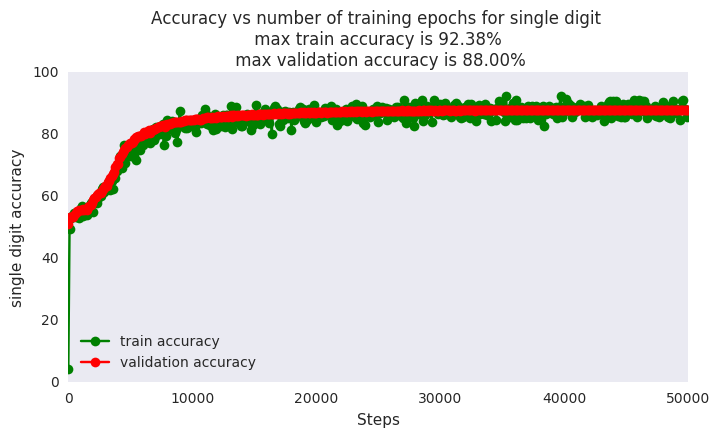

In [448]:
plot_train_valid(train_accuracy_s_m2, valid_accuracy_s_m2, 50000, 'single digit')

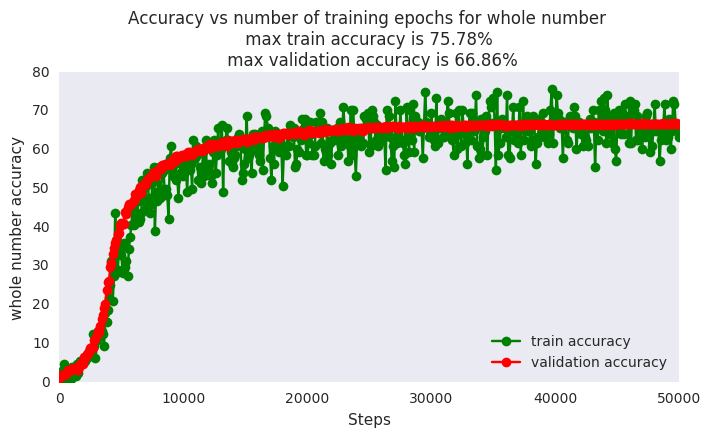

In [449]:
plot_train_valid(train_accuracy_n_m2, valid_accuracy_n_m2, 50000, 'whole number')

In [450]:
print("Training time for Model 2 is %d min" % int(training_time_f_m2/60))

Training time for Model 2 is 22 min


### Results:

#### Model 1

* **Best Minibatch single digit accuracy: 94.9%**
* **Best Minibatch whole number accuracy: 86.7%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.7%**

#### Model 2

====================================<br />
Train ConvNet<br />
data [128, 32, 32, 1]<br />
hidden conv1 [128, 32, 32, 16]<br />
pool 1 [128, 16, 16, 16]<br />
hidden conv2 [128, 16, 16, 32]<br />
pool 2 [128, 8, 8, 32]<br />
hidden conv3 [128, 8, 8, 64]<br />
pool 3 [128, 4, 4, 64]<br />
reshape_pool [128, 1024]<br />
hidden fuc1 [128, 1024]<br />
hidden fuc2 [128, 256]<br />
output layer for digit 1 [128, 11]<br />
output layer for digit 2 [128, 11]<br />
output layer for digit 3 [128, 11]<br />
output layer for digit 4 [128, 11]<br />
====================================<br />

* **Best Minibatch single digit accuracy: 92.4%**
* **Best Minibatch whole number accuracy: 75.8%**
* **Best Validation single digit accuracy: 88.0%**
* **Best Validation whole number accuracy: 66.9%**
* **Best Test single digit accuracy: 88.4%**
* **Best Test whole number accuracy: 68.3%**

Performance of the Model 2 is slightly worse compare to Model 1. May be beta, learning rates needed to be tuned in order to get better performance. 

We will add one more convolutional layer Modell 1 to see if it improves the performance of Model 1 or not. In addition we will perform some beta, learning rate decay rate tuning for better performance.

### Let's change the strategy and make Model 1 more complex by adding one more convolutional layer to it. Model 3 will have 4 convolutional layers and one fully connected layers.

### In addition we will do a quick search (10000 epochs per condition) of beta (L2 regularization), and learning rate (starting learning rate will be the same)

In [528]:
# variables defined earlier
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 128
patch_size = 5
depth = [8, 16, 32, 64]
num_hidden = 1024
betas = [0.01, 0.0075, 0.005, 0.0025] # L2 regularization constant for all layers
learning_rates = [0.875, 0.9, 0.925, 0.95] # learning rate decay 
num_steps = 10001

# prepare dictionaries to save accuracy for each beta
train_accuracy_s_b_m3 = {}
valid_accuracy_s_b_m3 = {}
test_accuracy_s_b_m3 = {}
train_accuracy_n_b_m3 = {}
valid_accuracy_n_b_m3 = {}
test_accuracy_n_b_m3 = {}

for beta in betas:
    for l_rate in learning_rates:
        #########################################

        graph = tf.Graph()

        with graph.as_default():

            with tf.device('/gpu:1'):
            #with tf.device('/cpu:0'):
                # helper functions

                def layer_weights(dimentions):
                    """
                    this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
                    """ 
                    return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
                def layer_biases(value, dimentions):
                    """
                    this function return  tf.Variable(tf.constant(value, shape=dimentions))
                    """
                    return tf.Variable(tf.constant(value, shape=dimentions))

                # Input data.
                tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
                tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
                tf_valid_dataset = tf.constant(valid_dataset)
                tf_test_dataset = tf.constant(test_dataset)

                # Variables.
                # conv layers
                l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
                l1_b = layer_biases(0., [depth[0]])

                l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
                l2_b = layer_biases(1.0, [depth[1]])

                l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
                l3_b = layer_biases(1.0, [depth[2]])

                l3b_w = layer_weights([patch_size, patch_size, depth[2], depth[3]])
                l3b_b = layer_biases(1.0, [depth[3]])

                # fully connected flat layer
                l4_w = layer_weights([image_size // 16 * image_size // 16 * depth[3], num_hidden])
                l4_b = layer_biases(1.0, [num_hidden])

                # locally connected digit layers
                l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
                l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

                # Model.
                def model(data, train = True):
                  print('data', data.get_shape().as_list())

                  conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
                  hidden = tf.nn.relu(conv + l1_b)
                  print('hidden conv1', hidden.get_shape().as_list())

                  pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                  print('pool 1', pool.get_shape().as_list())

                  conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
                  hidden = tf.nn.relu(conv + l2_b)
                  print('hidden conv2', hidden.get_shape().as_list())

                  pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                  print('pool 2', pool.get_shape().as_list())

                  conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
                  hidden = tf.nn.relu(conv + l3_b)
                  print('hidden conv3', hidden.get_shape().as_list())

                  pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                  print('pool 3', pool.get_shape().as_list())

                  conv = tf.nn.conv2d(pool, l3b_w, [1, 1, 1, 1], padding='SAME')
                  hidden = tf.nn.relu(conv + l3b_b)
                  print('hidden conv4', hidden.get_shape().as_list())

                  pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                  print('pool 4', pool.get_shape().as_list())

                  shape = pool.get_shape().as_list()
                  print("shape before flatten", shape)
                  reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
                  print("reshape_pool", reshape.get_shape().as_list())

                  hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
                  if train:
                      hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
                  print('hidden fuc1', hidden.get_shape().as_list())

                  final = []
                  for idx in range(num_digits):
                        final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                        print("output layer for digit", idx+1, final[idx].get_shape().as_list())
                  return final

                # Training computation.
                print("====================================")
                print("Train ConvNet")
                logits = model(tf_train_dataset)

                reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) + tf.nn.l2_loss(l3_w)
                                     + tf.nn.l2_loss(l3b_w) + tf.nn.l2_loss(l4_w))

                loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                              tf_train_labels[:, idx])) + reg_hidden + 
                              beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

                loss_final = tf.add_n(loss_digit)

                # Optimizer.
                global_step = tf.Variable(0)  # count the number of steps taken.
                learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, l_rate)
                optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

                # Predictions for the training, validation, and test data.
                def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
                    """
                    predicting labels base on the current model
                    """
                    predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
                    predictions = tf.pack(predictions_tmp)
                    shape = predictions.get_shape().as_list()
                    return predictions

                train_prediction = predictions_tf(logits)
                print("Train predictions shape", train_prediction.get_shape().as_list())
                print("====================================")
                print("Valid ConvNet")
                valid_prediction = predictions_tf(model(tf_valid_dataset, False))
                print("Valid predictions shape", valid_prediction.get_shape().as_list())
                print("====================================")
                print("Test ConvNet")
                test_prediction = predictions_tf(model(tf_test_dataset, False))
                print("Test predictions shape", test_prediction.get_shape().as_list())

        # prepare dictionaries to save accuracies for every 100 steps
        train_accuracy_s_m3 = {}
        valid_accuracy_s_m3 = {}
        train_accuracy_n_m3 = {}
        valid_accuracy_n_m3 = {}

        start = time.time()

        with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
            if sys.version_info.major == 2:
                print("Initializing variables")
                tf.initialize_all_variables().run()
            elif sys.version_info.major == 3: 
                print("Initializing variables") 
                tf.global_variables_initializer().run()
            else:
                print("I can't run it on this version of python")

            print("====================================")
            print("Initialized with batch size = %d, regularizaton beta = %f, and learning rate decay rate %.2f" % (batch_size, beta, l_rate))

            for step in range(num_steps):
                offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
                batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

                batch_labels = train_labels_n[offset:(offset + batch_size), :]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
                _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
                end = time.time()
                if (step % 100 == 0):
                  train_accuracy_s_m3[step] = accuracy_single(predictions, batch_labels)    
                  valid_accuracy_s_m3[step] = accuracy_single(valid_prediction.eval(), valid_labels)
                  train_accuracy_n_m3[step] = accuracy_number(predictions, batch_labels)    
                  valid_accuracy_n_m3[step] = accuracy_number(valid_prediction.eval(), valid_labels)
                  if (step % 1000 == 0):
                      print("Learning rate: %f" % learning_rate.eval())
                      print('Minibatch loss at step %d: %f' % (step, l))

                      print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m3[step])
                      print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m3[step])

                      print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m3[step])  
                      print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m3[step])

            test_predictions_final_m3 = test_prediction.eval()
            test_accuracy_s_m3 = accuracy_single(test_predictions_final_m3, test_labels)
            test_accuracy_n_m3 = accuracy_number(test_predictions_final_m3, test_labels)
            print('Test single digit accuracy: %.1f%%' % test_accuracy_s_m3)
            print('Test whole number accuracy: %.1f%%' % test_accuracy_n_m3)

            train_accuracy_s_b_m3[(beta, l_rate)] = train_accuracy_s_m3[step]
            valid_accuracy_s_b_m3[(beta, l_rate)] = valid_accuracy_s_m3[step]
            test_accuracy_s_b_m3[(beta, l_rate)] = test_accuracy_s_m3
            train_accuracy_n_b_m3[(beta, l_rate)] = train_accuracy_n_m3[step]
            valid_accuracy_n_b_m3[(beta, l_rate)] = valid_accuracy_n_m3[step]
            test_accuracy_n_b_m3[(beta, l_rate)] = test_accuracy_n_m3

        print("Total training time is %f" % (end - start))

Train ConvNet
data [128, 32, 32, 1]
hidden conv1 [128, 32, 32, 8]
pool 1 [128, 16, 16, 8]
hidden conv2 [128, 16, 16, 16]
pool 2 [128, 8, 8, 16]
hidden conv3 [128, 8, 8, 32]
pool 3 [128, 4, 4, 32]
hidden conv4 [128, 4, 4, 64]
pool 4 [128, 2, 2, 64]
shape before flatten [128, 2, 2, 64]
reshape_pool [128, 256]
hidden fuc1 [128, 1024]
output layer for digit 1 [128, 11]
output layer for digit 2 [128, 11]
output layer for digit 3 [128, 11]
output layer for digit 4 [128, 11]
Train predictions shape [4, 128, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 8]
pool 1 [6968, 16, 16, 8]
hidden conv2 [6968, 16, 16, 16]
pool 2 [6968, 8, 8, 16]
hidden conv3 [6968, 8, 8, 32]
pool 3 [6968, 4, 4, 32]
hidden conv4 [6968, 4, 4, 64]
pool 4 [6968, 2, 2, 64]
shape before flatten [6968, 2, 2, 64]
reshape_pool [6968, 256]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
V

In [529]:
def plot_heat_maps(tmp_dic, tmp_title):
    
    tmp_df = pd.DataFrame(tmp_dic.values(), index=pd.MultiIndex.from_tuples(tmp_dic.keys(), 
                                    names=['beta', 'learning rate decay rate']), columns=['Accuracy'])
    tmp_df = tmp_df.reset_index(level=['beta', 'learning rate decay rate'])
    tmp_df['Accuracy'] = tmp_df.Accuracy[0]
    tmp_heat = tmp_df.pivot('beta', 'learning rate decay rate', 'Accuracy')
    sns.heatmap(tmp_heat, annot=True, annot_kws={'fontsize': 10},  fmt = '.2f')
    sns.plt.title('Heat map of '+tmp_title+' in %')
    return tmp_df

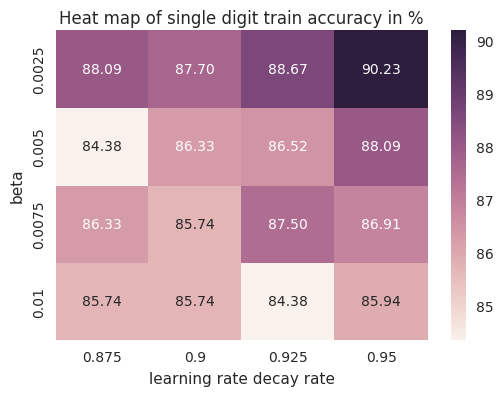

In [530]:
train_accuracy_s_b_m3_df = plot_heat_maps(train_accuracy_s_b_m3, 'single digit train accuracy')

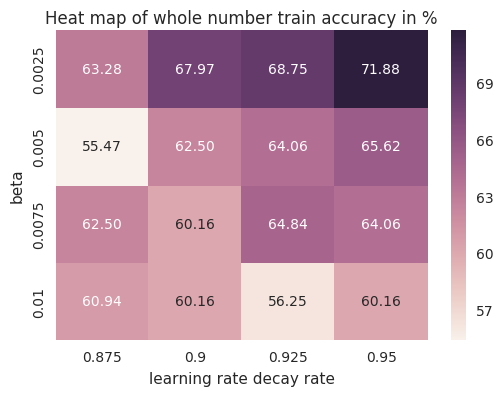

In [532]:
train_accuracy_n_b_m3_df = plot_heat_maps(train_accuracy_n_b_m3, 'whole number train accuracy')

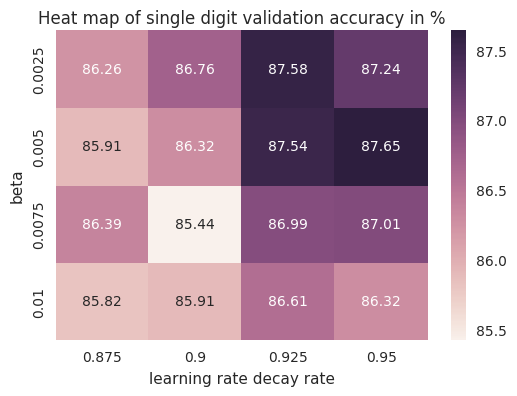

In [533]:
valid_accuracy_s_b_m3_df = plot_heat_maps(valid_accuracy_s_b_m3, 'single digit validation accuracy')

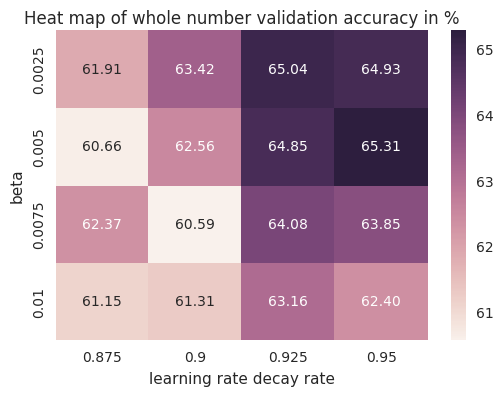

In [534]:
valid_accuracy_n_b_m3_df = plot_heat_maps(valid_accuracy_n_b_m3, 'whole number validation accuracy')

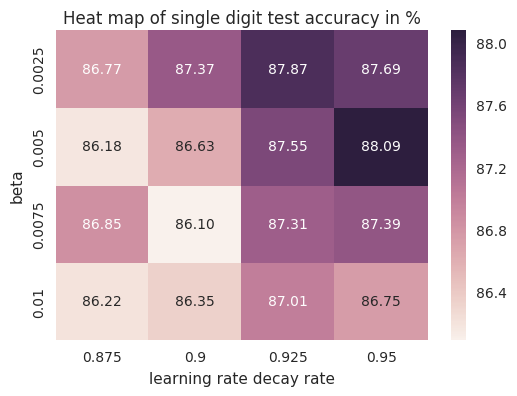

In [535]:
test_accuracy_s_b_m3_df = plot_heat_maps(test_accuracy_s_b_m3, 'single digit test accuracy')

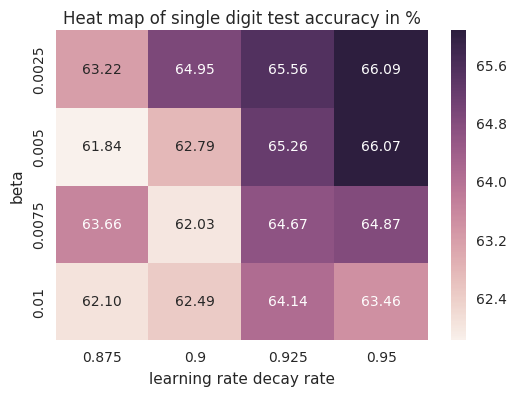

In [536]:
test_accuracy_n_b_m3_df = plot_heat_maps(test_accuracy_n_b_m3, 'single digit test accuracy')

### Base on the validation heat maps and purpose of the project of accurate recognition of the number we will be using beta=0.005 and learning rate decay rate of 0.95 with decay step of 1000 for the future modelling.

### Check performance of Model_3 with patch size 3, 5, 8 and 10000 epochs, beta = 0.005, learning rate decay rate is 0.95.

In [537]:
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 128
patch_sizes = [4, 5, 6]
depth = [8, 16, 32, 64]
num_hidden = 1024
beta = 0.005 # L2 regularization constant for all layers
l_rate = 0.95 # learning rate decay 
num_steps = 10001

# prepare dictionaries to save accuracy for each beta
train_accuracy_s_ps_m3 = {}
valid_accuracy_s_ps_m3 = {}
test_accuracy_s_ps_m3 = {}
train_accuracy_n_ps_m3 = {}
valid_accuracy_n_ps_m3 = {}
test_accuracy_n_ps_m3 = {}
training_time_ps_m3 = {}

for patch_size in patch_sizes:

    #########################################

    graph = tf.Graph()

    with graph.as_default():

        with tf.device('/gpu:1'):
        #with tf.device('/cpu:0'):
            # helper functions

            def layer_weights(dimentions):
                """
                this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
                """ 
                return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
            def layer_biases(value, dimentions):
                """
                this function return  tf.Variable(tf.constant(value, shape=dimentions))
                """
                return tf.Variable(tf.constant(value, shape=dimentions))

            # Input data.
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
            tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

            # Variables.
            # conv layers
            l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
            l1_b = layer_biases(0., [depth[0]])

            l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
            l2_b = layer_biases(1.0, [depth[1]])

            l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
            l3_b = layer_biases(1.0, [depth[2]])

            l3b_w = layer_weights([patch_size, patch_size, depth[2], depth[3]])
            l3b_b = layer_biases(1.0, [depth[3]])

            # fully connected flat layer
            l4_w = layer_weights([image_size // 16 * image_size // 16 * depth[3], num_hidden])
            l4_b = layer_biases(1.0, [num_hidden])

            # locally connected digit layers
            l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
            l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

            # Model.
            def model(data, train = True):
              print('data', data.get_shape().as_list())

              conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
              hidden = tf.nn.relu(conv + l1_b)
              print('hidden conv1', hidden.get_shape().as_list())

              pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
              print('pool 1', pool.get_shape().as_list())

              conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
              hidden = tf.nn.relu(conv + l2_b)
              print('hidden conv2', hidden.get_shape().as_list())

              pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
              print('pool 2', pool.get_shape().as_list())

              conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
              hidden = tf.nn.relu(conv + l3_b)
              print('hidden conv3', hidden.get_shape().as_list())

              pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
              print('pool 3', pool.get_shape().as_list())

              conv = tf.nn.conv2d(pool, l3b_w, [1, 1, 1, 1], padding='SAME')
              hidden = tf.nn.relu(conv + l3b_b)
              print('hidden conv4', hidden.get_shape().as_list())

              pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
              print('pool 4', pool.get_shape().as_list())

              shape = pool.get_shape().as_list()
              print("shape before flatten", shape)
              reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
              print("reshape_pool", reshape.get_shape().as_list())

              hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
              if train:
                  hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
              print('hidden fuc1', hidden.get_shape().as_list())

              final = []
              for idx in range(num_digits):
                    final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                    print("output layer for digit", idx+1, final[idx].get_shape().as_list())
              return final

            # Training computation.
            print("====================================")
            print("Train ConvNet")
            logits = model(tf_train_dataset)

            reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) + tf.nn.l2_loss(l3_w)
                                 + tf.nn.l2_loss(l3b_w) + tf.nn.l2_loss(l4_w))

            loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                          tf_train_labels[:, idx])) + reg_hidden + 
                          beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

            loss_final = tf.add_n(loss_digit)

            # Optimizer.
            global_step = tf.Variable(0)  # count the number of steps taken.
            learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, l_rate)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

            # Predictions for the training, validation, and test data.
            def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
                """
                predicting labels base on the current model
                """
                predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
                predictions = tf.pack(predictions_tmp)
                shape = predictions.get_shape().as_list()
                return predictions

            train_prediction = predictions_tf(logits)
            print("Train predictions shape", train_prediction.get_shape().as_list())
            print("====================================")
            print("Valid ConvNet")
            valid_prediction = predictions_tf(model(tf_valid_dataset, False))
            print("Valid predictions shape", valid_prediction.get_shape().as_list())
            print("====================================")
            print("Test ConvNet")
            test_prediction = predictions_tf(model(tf_test_dataset, False))
            print("Test predictions shape", test_prediction.get_shape().as_list())

    # prepare dictionaries to save accuracies for every 100 steps
    train_accuracy_s_m3 = {}
    valid_accuracy_s_m3 = {}
    test_accuracy_s_m3 = {}
    train_accuracy_n_m3 = {}
    valid_accuracy_n_m3 = {}
    test_accuracy_n_m3 = {}

    start = time.time()

    with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
        if sys.version_info.major == 2:
            print("Initializing variables")
            tf.initialize_all_variables().run()
        elif sys.version_info.major == 3: 
            print("Initializing variables") 
            tf.global_variables_initializer().run()
        else:
            print("I can't run it on this version of python")

        print("====================================")
        print("Initialized with patch size = %d, regularizaton beta = %f, and learning rate decay rate %.2f" % (patch_size, beta, l_rate))

        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
            batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

            batch_labels = train_labels_n[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
            end = time.time()
            if (step % 100 == 0):
              train_accuracy_s_m3[step] = accuracy_single(predictions, batch_labels)    
              valid_accuracy_s_m3[step] = accuracy_single(valid_prediction.eval(), valid_labels)
              train_accuracy_n_m3[step] = accuracy_number(predictions, batch_labels)    
              valid_accuracy_n_m3[step] = accuracy_number(valid_prediction.eval(), valid_labels)
              test_predictions_final_m3 = test_prediction.eval()
              test_accuracy_s_m3[step] = accuracy_single(test_predictions_final_m3, test_labels)
              test_accuracy_n_m3[step] = accuracy_number(test_predictions_final_m3, test_labels)
              if (step % 1000 == 0):
                  print("Learning rate: %f" % learning_rate.eval())
                  print('Minibatch loss at step %d: %f' % (step, l))

                  print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m3[step])
                  print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m3[step])

                  print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m3[step])  
                  print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m3[step])

        print('Test single digit accuracy: %.1f%%' % test_accuracy_s_m3[step])
        print('Test whole number accuracy: %.1f%%' % test_accuracy_n_m3[step])

        train_accuracy_s_ps_m3[patch_size] = max(train_accuracy_s_m3.values())
        valid_accuracy_s_ps_m3[patch_size] = max(valid_accuracy_s_m3.values())
        test_accuracy_s_ps_m3[patch_size] = max(test_accuracy_s_m3.values())
        train_accuracy_n_ps_m3[patch_size] = max(train_accuracy_n_m3.values())
        valid_accuracy_n_ps_m3[patch_size] = max(valid_accuracy_n_m3.values())
        test_accuracy_n_ps_m3[patch_size] = max(test_accuracy_n_m3.values())

    print("Total training time is %f" % (end - start))

Train ConvNet
data [128, 32, 32, 1]
hidden conv1 [128, 32, 32, 8]
pool 1 [128, 16, 16, 8]
hidden conv2 [128, 16, 16, 16]
pool 2 [128, 8, 8, 16]
hidden conv3 [128, 8, 8, 32]
pool 3 [128, 4, 4, 32]
hidden conv4 [128, 4, 4, 64]
pool 4 [128, 2, 2, 64]
shape before flatten [128, 2, 2, 64]
reshape_pool [128, 256]
hidden fuc1 [128, 1024]
output layer for digit 1 [128, 11]
output layer for digit 2 [128, 11]
output layer for digit 3 [128, 11]
output layer for digit 4 [128, 11]
Train predictions shape [4, 128, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 8]
pool 1 [6968, 16, 16, 8]
hidden conv2 [6968, 16, 16, 16]
pool 2 [6968, 8, 8, 16]
hidden conv3 [6968, 8, 8, 32]
pool 3 [6968, 4, 4, 32]
hidden conv4 [6968, 4, 4, 64]
pool 4 [6968, 2, 2, 64]
shape before flatten [6968, 2, 2, 64]
reshape_pool [6968, 256]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
V

In [538]:
# show patch size vs accuracy
def plot_heat_maps_patch(tmp_dic_train, tmp_dic_valid, tmp_dic_test, tmp_title):
    """
    plots heat map of batch size vs accuracy for 
    tmp_dic_train: training dictionary with batch size keys and accuracy as values
    tmp_dic_valid: validation dictionary with batch size keys and accuracy as values
    tmp_dic_test: test dictionary with batch size keys and accuracy as values
    tmp_title: string to add to the plot's title
    """
    tmp_df = pd.DataFrame.from_dict(tmp_dic_train, 'index')
    tmp_df.columns = ['train accuracy']
    tmp_df['valid accuracy'] = tmp_dic_valid.values()
    tmp_df['test accuracy'] = tmp_dic_test.values()
    sns.heatmap(tmp_df, annot=True, annot_kws={'fontsize': 10},  fmt = '.2f')
    plt.ylabel('Patch size')
    plt.xlabel('Accuracy, %')
    sns.plt.title('Heat map of '+tmp_title+' accuracies in %')
    return tmp_df

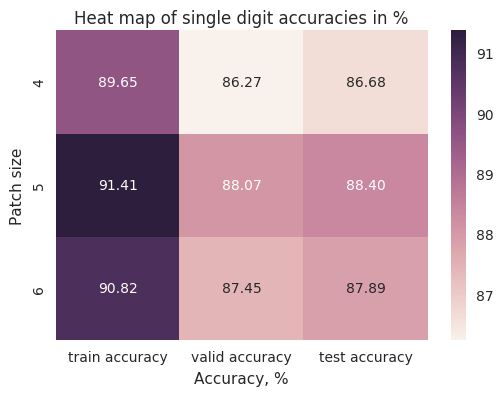

In [539]:
patch_accuracy_s_df = plot_heat_maps_patch(train_accuracy_s_ps_m3, valid_accuracy_s_ps_m3, test_accuracy_s_ps_m3, 'single digit')

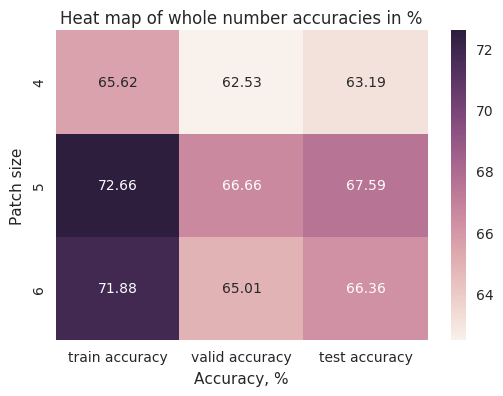

In [540]:
patch_accuracy_n_df = plot_heat_maps_patch(train_accuracy_n_ps_m3, valid_accuracy_n_ps_m3, test_accuracy_n_ps_m3, 'whole number')

### Model 3: batch size = 128, 4 convolutional layers, 1 fully connected layer, patch size = 5, beta (all layers) = 0.005, starting learning rate = 0.01, learning rate decay rate = 0.95 every 1000 steps, number of epochs=50000

In [541]:
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 128
patch_size = 5
depth = [8, 16, 32, 64]
num_hidden = 1024
beta = 0.005 # L2 regularization constant for all layers
l_rate = 0.95 # learning rate decay 
num_steps = 50001

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        l3b_w = layer_weights([patch_size, patch_size, depth[2], depth[3]])
        l3b_b = layer_biases(1.0, [depth[3]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 16 * image_size // 16 * depth[3], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3b_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3b_b)
          print('hidden conv4', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 4', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) + tf.nn.l2_loss(l3_w)
                             + tf.nn.l2_loss(l3b_w) + tf.nn.l2_loss(l4_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, l_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m3 = {}
valid_accuracy_s_m3 = {}
test_accuracy_s_m3 = {}
train_accuracy_n_m3 = {}
valid_accuracy_n_m3 = {}
test_accuracy_n_m3 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables") 
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with patch size = %d, regularizaton beta = %f, and learning rate decay rate %.2f" % (patch_size, beta, l_rate))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
        batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels_n[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m3[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m3[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m3[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m3[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final_m3 = test_prediction.eval()
          test_accuracy_s_m3[step] = accuracy_single(test_predictions_final_m3, test_labels)
          test_accuracy_n_m3[step] = accuracy_number(test_predictions_final_m3, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m3[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m3[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m3[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m3[step])

    print('Best Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m3.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m3.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m3.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m3.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m3.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m3.values()))
    
training_time_f_m3 = end - start
print("Total training time is %f" % training_time_f_m3)

Train ConvNet
data [128, 32, 32, 1]
hidden conv1 [128, 32, 32, 8]
pool 1 [128, 16, 16, 8]
hidden conv2 [128, 16, 16, 16]
pool 2 [128, 8, 8, 16]
hidden conv3 [128, 8, 8, 32]
pool 3 [128, 4, 4, 32]
hidden conv4 [128, 4, 4, 64]
pool 4 [128, 2, 2, 64]
shape before flatten [128, 2, 2, 64]
reshape_pool [128, 256]
hidden fuc1 [128, 1024]
output layer for digit 1 [128, 11]
output layer for digit 2 [128, 11]
output layer for digit 3 [128, 11]
output layer for digit 4 [128, 11]
Train predictions shape [4, 128, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 8]
pool 1 [6968, 16, 16, 8]
hidden conv2 [6968, 16, 16, 16]
pool 2 [6968, 8, 8, 16]
hidden conv3 [6968, 8, 8, 32]
pool 3 [6968, 4, 4, 32]
hidden conv4 [6968, 4, 4, 64]
pool 4 [6968, 2, 2, 64]
shape before flatten [6968, 2, 2, 64]
reshape_pool [6968, 256]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
V

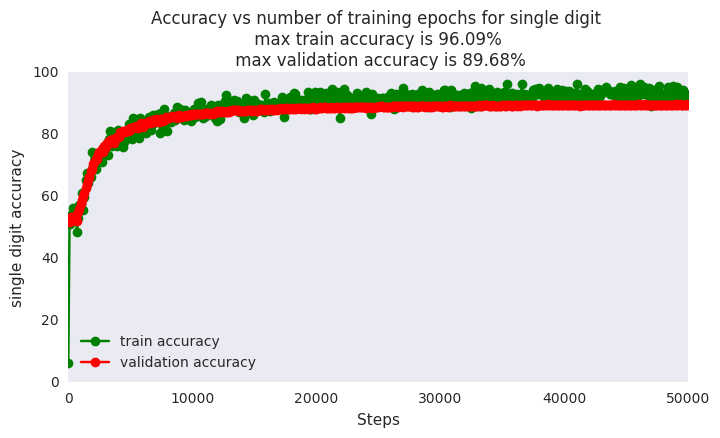

In [543]:
plot_train_valid(train_accuracy_s_m3, valid_accuracy_s_m3, 50000, 'single digit')

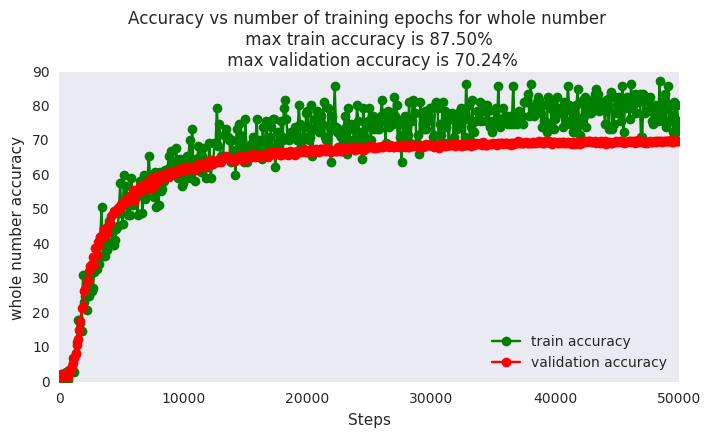

In [544]:
plot_train_valid(train_accuracy_n_m3, valid_accuracy_n_m3, 50000, 'whole number')

In [545]:
print("Training time for Model 3 is %d min" % int(training_time_f_m3/60))

Training time for Model 3 is 17 min


### Results:
#### Model 1
* **Best Minibatch single digit accuracy: 94.9%**
* **Best Minibatch whole number accuracy: 86.7%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.7%**

#### Model 2
* **Best Minibatch single digit accuracy: 92.4%**
* **Best Minibatch whole number accuracy: 75.8%**
* **Best Validation single digit accuracy: 88.0%**
* **Best Validation whole number accuracy: 66.9%**
* **Best Test single digit accuracy: 88.4%**
* **Best Test whole number accuracy: 68.3%**

#### Model 3

====================================<br />
Train ConvNet<br />
data [128, 32, 32, 1]<br />
hidden conv1 [128, 32, 32, 8]<br />
pool 1 [128, 16, 16, 8]<br />
hidden conv2 [128, 16, 16, 16]<br />
pool 2 [128, 8, 8, 16]<br />
hidden conv3 [128, 8, 8, 32]<br />
pool 3 [128, 4, 4, 32]<br />
hidden conv4 [128, 4, 4, 64]<br />
pool 4 [128, 2, 2, 64]<br />
hidden fuc1 [128, 1024]<br />
output layer for digit 1 [128, 11]<br />
output layer for digit 2 [128, 11]<br />
output layer for digit 3 [128, 11]<br />
output layer for digit 4 [128, 11]<br />
====================================<br />

* **Best Minibatch single digit accuracy: 96.1%**
* **Best Minibatch whole number accuracy: 87.5%**
* **Best Validation single digit accuracy: 89.7%**
* **Best Validation whole number accuracy: 70.2%**
* **Best Test single digit accuracy: 89.9%**
* **Best Test whole number accuracy: 71.7%**

Model 3 improve training minibatch accuracies. The best validation and test accuracies are about the same for all 3 models.

### Model 4: test a different optimazer: AdamOptimizer

In [546]:
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 128
patch_size = 5
depth = [8, 16, 32, 64]
num_hidden = 1024
beta = 0.005 # L2 regularization constant for all layers
l_rate = 0.95 # learning rate decay 
num_steps = 50001

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        l3b_w = layer_weights([patch_size, patch_size, depth[2], depth[3]])
        l3b_b = layer_biases(1.0, [depth[3]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 16 * image_size // 16 * depth[3], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3b_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3b_b)
          print('hidden conv4', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 4', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) + tf.nn.l2_loss(l3_w)
                             + tf.nn.l2_loss(l3b_w) + tf.nn.l2_loss(l4_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, l_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m4 = {}
valid_accuracy_s_m4 = {}
test_accuracy_s_m4 = {}
train_accuracy_n_m4 = {}
valid_accuracy_n_m4 = {}
test_accuracy_n_m4 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables") 
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with patch size = %d, regularizaton beta = %f, and learning rate decay rate %.2f" % (patch_size, beta, l_rate))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
        batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels_n[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m4[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m4[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m4[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m4[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final_m4 = test_prediction.eval()
          test_accuracy_s_m4[step] = accuracy_single(test_predictions_final_m4, test_labels)
          test_accuracy_n_m4[step] = accuracy_number(test_predictions_final_m4, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m4[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m4[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m4[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m4[step])

    print('Best Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m4.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m4.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m4.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m4.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m4.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m4.values()))
    
training_time_f_m4 = end - start
print("Total training time is %f" % training_time_f_m4)

Train ConvNet
data [128, 32, 32, 1]
hidden conv1 [128, 32, 32, 8]
pool 1 [128, 16, 16, 8]
hidden conv2 [128, 16, 16, 16]
pool 2 [128, 8, 8, 16]
hidden conv3 [128, 8, 8, 32]
pool 3 [128, 4, 4, 32]
hidden conv4 [128, 4, 4, 64]
pool 4 [128, 2, 2, 64]
shape before flatten [128, 2, 2, 64]
reshape_pool [128, 256]
hidden fuc1 [128, 1024]
output layer for digit 1 [128, 11]
output layer for digit 2 [128, 11]
output layer for digit 3 [128, 11]
output layer for digit 4 [128, 11]
Train predictions shape [4, 128, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 8]
pool 1 [6968, 16, 16, 8]
hidden conv2 [6968, 16, 16, 16]
pool 2 [6968, 8, 8, 16]
hidden conv3 [6968, 8, 8, 32]
pool 3 [6968, 4, 4, 32]
hidden conv4 [6968, 4, 4, 64]
pool 4 [6968, 2, 2, 64]
shape before flatten [6968, 2, 2, 64]
reshape_pool [6968, 256]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
V

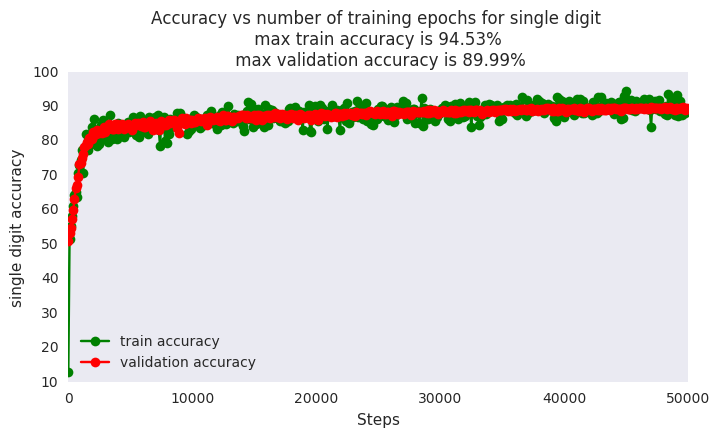

In [547]:
plot_train_valid(train_accuracy_s_m4, valid_accuracy_s_m4, 50000, 'single digit')

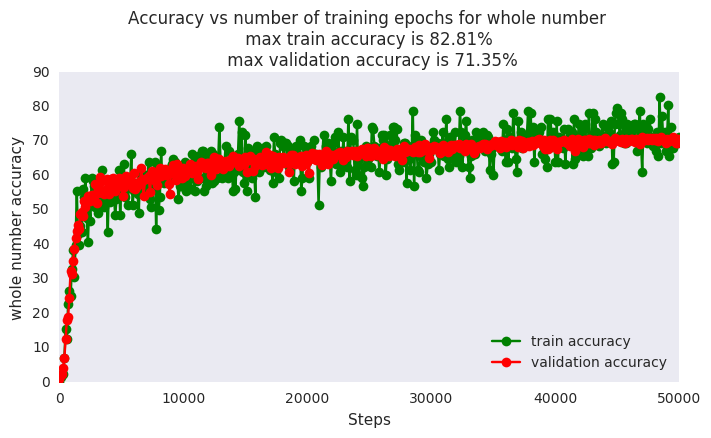

In [548]:
plot_train_valid(train_accuracy_n_m4, valid_accuracy_n_m4, 50000, 'whole number')

In [549]:
print("Training time for Model 4 is %d min" % int(training_time_f_m4/60))

Training time for Model 4 is 17 min


### Results:
### Results:
#### Model 1
* **Best Minibatch single digit accuracy: 94.9%**
* **Best Minibatch whole number accuracy: 86.7%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.7%**

#### Model 2
* **Best Minibatch single digit accuracy: 92.4%**
* **Best Minibatch whole number accuracy: 75.8%**
* **Best Validation single digit accuracy: 88.0%**
* **Best Validation whole number accuracy: 66.9%**
* **Best Test single digit accuracy: 88.4%**
* **Best Test whole number accuracy: 68.3%**

#### Model 3
* **Best Minibatch single digit accuracy: 96.1%**
* **Best Minibatch whole number accuracy: 87.5%**
* **Best Validation single digit accuracy: 89.7%**
* **Best Validation whole number accuracy: 70.2%**
* **Best Test single digit accuracy: 89.9%**
* **Best Test whole number accuracy: 71.7%**


#### Model 4
* **Best Minibatch single digit accuracy: 94.5%**
* **Best Minibatch whole number accuracy: 82.8%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.0%**
* **Best Test whole number accuracy: 71.5%**

### Model 5: as Model 3 with batch size 256 and 50000 epoches. 

In [551]:
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 256
patch_size = 5
depth = [8, 16, 32, 64]
num_hidden = 1024
beta = 0.005 # L2 regularization constant for all layers
l_rate = 0.95 # learning rate decay 
num_steps = 50001

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        l3b_w = layer_weights([patch_size, patch_size, depth[2], depth[3]])
        l3b_b = layer_biases(1.0, [depth[3]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 16 * image_size // 16 * depth[3], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3b_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3b_b)
          print('hidden conv4', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 4', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) + tf.nn.l2_loss(l3_w)
                             + tf.nn.l2_loss(l3b_w) + tf.nn.l2_loss(l4_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, l_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m5 = {}
valid_accuracy_s_m5 = {}
test_accuracy_s_m5 = {}
train_accuracy_n_m5 = {}
valid_accuracy_n_m5 = {}
test_accuracy_n_m5 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables") 
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with patch size = %d, regularizaton beta = %f, and learning rate decay rate %.2f" % (patch_size, beta, l_rate))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
        batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels_n[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m5[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m5[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m5[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m5[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final_m5 = test_prediction.eval()
          test_accuracy_s_m5[step] = accuracy_single(test_predictions_final_m5, test_labels)
          test_accuracy_n_m5[step] = accuracy_number(test_predictions_final_m5, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m5[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m5[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m5[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m5[step])

    print('Best Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m5.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m5.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m5.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m5.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m5.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m5.values()))
    
training_time_f_m5 = end - start
print("Total training time is %f" % training_time_f_m5)

Train ConvNet
data [256, 32, 32, 1]
hidden conv1 [256, 32, 32, 8]
pool 1 [256, 16, 16, 8]
hidden conv2 [256, 16, 16, 16]
pool 2 [256, 8, 8, 16]
hidden conv3 [256, 8, 8, 32]
pool 3 [256, 4, 4, 32]
hidden conv4 [256, 4, 4, 64]
pool 4 [256, 2, 2, 64]
shape before flatten [256, 2, 2, 64]
reshape_pool [256, 256]
hidden fuc1 [256, 1024]
output layer for digit 1 [256, 11]
output layer for digit 2 [256, 11]
output layer for digit 3 [256, 11]
output layer for digit 4 [256, 11]
Train predictions shape [4, 256, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 8]
pool 1 [6968, 16, 16, 8]
hidden conv2 [6968, 16, 16, 16]
pool 2 [6968, 8, 8, 16]
hidden conv3 [6968, 8, 8, 32]
pool 3 [6968, 4, 4, 32]
hidden conv4 [6968, 4, 4, 64]
pool 4 [6968, 2, 2, 64]
shape before flatten [6968, 2, 2, 64]
reshape_pool [6968, 256]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
V

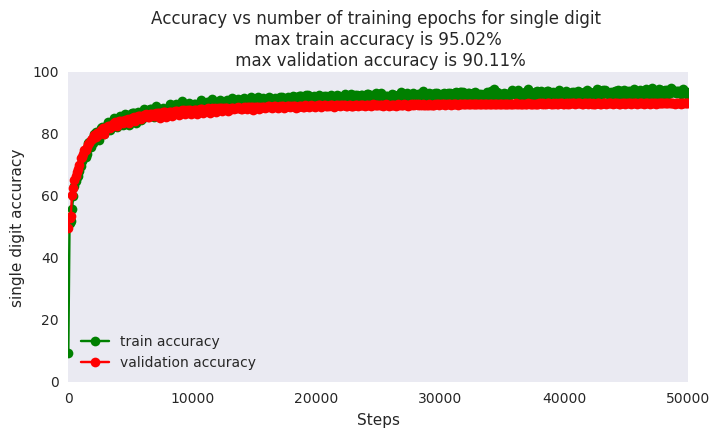

In [552]:
plot_train_valid(train_accuracy_s_m5, valid_accuracy_s_m5, 50000, 'single digit')

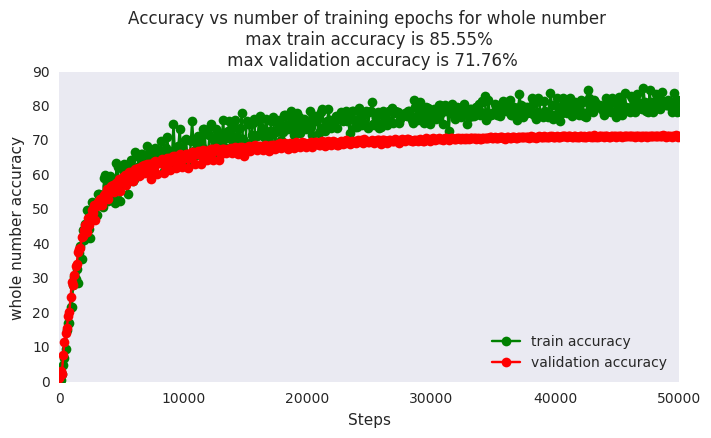

In [553]:
plot_train_valid(train_accuracy_n_m5, valid_accuracy_n_m5, 50000, 'whole number')

In [554]:
print("Training time for Model 5 is %d min" % int(training_time_f_m5/60))

Training time for Model 5 is 24 min


### Results:
#### Batch 128 models performances
#### Model 1
* **Best Minibatch single digit accuracy: 94.9%**
* **Best Minibatch whole number accuracy: 86.7%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.7%**

#### Model 2
* **Best Minibatch single digit accuracy: 92.4%**
* **Best Minibatch whole number accuracy: 75.8%**
* **Best Validation single digit accuracy: 88.0%**
* **Best Validation whole number accuracy: 66.9%**
* **Best Test single digit accuracy: 88.4%**
* **Best Test whole number accuracy: 68.3%**

#### Model 3
* **Best Minibatch single digit accuracy: 96.1%**
* **Best Minibatch whole number accuracy: 87.5%**
* **Best Validation single digit accuracy: 89.7%**
* **Best Validation whole number accuracy: 70.2%**
* **Best Test single digit accuracy: 89.9%**
* **Best Test whole number accuracy: 71.7%**


#### Model 4
* **Best Minibatch single digit accuracy: 94.5%**
* **Best Minibatch whole number accuracy: 82.8%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.0%**
* **Best Test whole number accuracy: 71.5%**

#### Batch 256 models performances

#### Model 5
* **Best Minibatch single digit accuracy: 95.0%**
* **Best Minibatch whole number accuracy: 85.5%**
* **Best Validation single digit accuracy: 90.1%**
* **Best Validation whole number accuracy: 71.8%**
* **Best Test single digit accuracy: 90.8%**
* **Best Test whole number accuracy: 73.5%**

### Model 6: as Model 4 with batch size 256 and 50000 epoches. 

In [ ]:
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 256
patch_size = 5
depth = [8, 16, 32, 64]
num_hidden = 1024
beta = 0.005 # L2 regularization constant for all layers
l_rate = 0.95 # learning rate decay 
num_steps = 50001

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        l3b_w = layer_weights([patch_size, patch_size, depth[2], depth[3]])
        l3b_b = layer_biases(1.0, [depth[3]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 16 * image_size // 16 * depth[3], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3b_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3b_b)
          print('hidden conv4', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 4', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) + tf.nn.l2_loss(l3_w)
                             + tf.nn.l2_loss(l3b_w) + tf.nn.l2_loss(l4_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, l_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m6 = {}
valid_accuracy_s_m6 = {}
test_accuracy_s_m6 = {}
train_accuracy_n_m6 = {}
valid_accuracy_n_m6 = {}
test_accuracy_n_m6 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables") 
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with batch size = %d, regularizaton beta = %f, and learning rate decay rate %.2f" % (batch_size, beta, l_rate))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
        batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels_n[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m6[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m6[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m6[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m6[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final_m6 = test_prediction.eval()
          test_accuracy_s_m6[step] = accuracy_single(test_predictions_final_m6, test_labels)
          test_accuracy_n_m6[step] = accuracy_number(test_predictions_final_m6, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m6[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m6[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m6[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m6[step])

    print('Best Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m6.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m6.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m6.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m6.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m6.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m6.values()))
    
training_time_f_m6 = end - start
print("Total training time is %f" % training_time_f_m6)

Train ConvNet
data [256, 32, 32, 1]
hidden conv1 [256, 32, 32, 8]
pool 1 [256, 16, 16, 8]
hidden conv2 [256, 16, 16, 16]
pool 2 [256, 8, 8, 16]
hidden conv3 [256, 8, 8, 32]
pool 3 [256, 4, 4, 32]
hidden conv4 [256, 4, 4, 64]
pool 4 [256, 2, 2, 64]
shape before flatten [256, 2, 2, 64]
reshape_pool [256, 256]
hidden fuc1 [256, 1024]
output layer for digit 1 [256, 11]
output layer for digit 2 [256, 11]
output layer for digit 3 [256, 11]
output layer for digit 4 [256, 11]
Train predictions shape [4, 256, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 8]
pool 1 [6968, 16, 16, 8]
hidden conv2 [6968, 16, 16, 16]
pool 2 [6968, 8, 8, 16]
hidden conv3 [6968, 8, 8, 32]
pool 3 [6968, 4, 4, 32]
hidden conv4 [6968, 4, 4, 64]
pool 4 [6968, 2, 2, 64]
shape before flatten [6968, 2, 2, 64]
reshape_pool [6968, 256]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
V

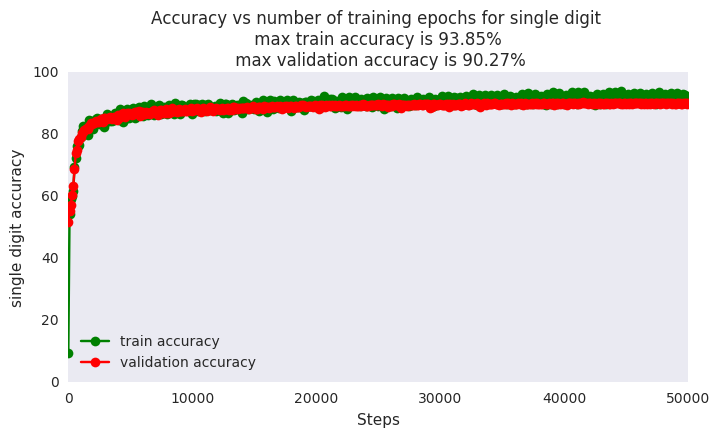

In [573]:
plot_train_valid(train_accuracy_s_m6, valid_accuracy_s_m6, 50000, 'single digit')

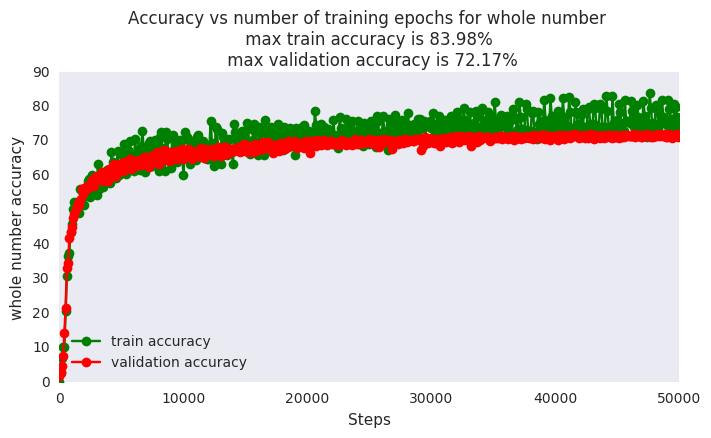

In [574]:
plot_train_valid(train_accuracy_n_m6, valid_accuracy_n_m6, 50000, 'whole number')

In [587]:
print("Training time for Model 6 is %d min" % int(training_time_f_m6/60))

Training time for Model 6 is 24 min


### Results:
#### Batch 128 models performances
#### Model 1
* **Best Minibatch single digit accuracy: 94.9%**
* **Best Minibatch whole number accuracy: 86.7%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.7%**

#### Model 2
* **Best Minibatch single digit accuracy: 92.4%**
* **Best Minibatch whole number accuracy: 75.8%**
* **Best Validation single digit accuracy: 88.0%**
* **Best Validation whole number accuracy: 66.9%**
* **Best Test single digit accuracy: 88.4%**
* **Best Test whole number accuracy: 68.3%**

#### Model 3
* **Best Minibatch single digit accuracy: 96.1%**
* **Best Minibatch whole number accuracy: 87.5%**
* **Best Validation single digit accuracy: 89.7%**
* **Best Validation whole number accuracy: 70.2%**
* **Best Test single digit accuracy: 89.9%**
* **Best Test whole number accuracy: 71.7%**


#### Model 4
* **Best Minibatch single digit accuracy: 94.5%**
* **Best Minibatch whole number accuracy: 82.8%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.0%**
* **Best Test whole number accuracy: 71.5%**

#### Batch 256 models performances

#### Model 5
* **Best Minibatch single digit accuracy: 95.0%**
* **Best Minibatch whole number accuracy: 85.5%**
* **Best Validation single digit accuracy: 90.1%**
* **Best Validation whole number accuracy: 71.8%**
* **Best Test single digit accuracy: 90.8%**
* **Best Test whole number accuracy: 73.5%**

#### Model 6
* **Best Minibatch single digit accuracy: 93.8%**
* **Best Minibatch whole number accuracy: 84.0%**
* **Best Validation single digit accuracy: 90.3%**
* **Best Validation whole number accuracy: 72.2%**
* **Best Test single digit accuracy: 90.7%**
* **Best Test whole number accuracy: 74.1%**

### Model 7: as Model 1 with batch size 256 and 50000 epoches.

In [575]:
# variables defined earlier
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 256
patch_size = 5
depth = [16, 32, 64]
num_hidden = 1024
beta = 0.0075

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 8 * image_size // 8 * depth[2], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) 
                             + tf.nn.l2_loss(l3_w) + tf.nn.l2_loss(l4_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, .9)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())

num_steps = 50001

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m7 = {}
valid_accuracy_s_m7 = {}
test_accuracy_s_m7 = {}
train_accuracy_n_m7 = {}
valid_accuracy_n_m7 = {}
test_accuracy_n_m7 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables")
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with batch size = %d and regularizaton beta = %f" % (batch_size, beta))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
        batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels_n[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m7[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m7[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m7[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m7[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final_m7 = test_prediction.eval()
          test_accuracy_s_m7[step] = accuracy_single(test_predictions_final_m7, test_labels)
          test_accuracy_n_m7[step] = accuracy_number(test_predictions_final_m7, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m7[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m7[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m7[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m7[step])
    
    print('Besst Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m7.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m7.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m7.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m7.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m7.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m7.values()))

training_time_f_m7 = end - start
print("Total training time is %f" % training_time_f_m7)

Train ConvNet
data [256, 32, 32, 1]
hidden conv1 [256, 32, 32, 16]
pool 1 [256, 16, 16, 16]
hidden conv2 [256, 16, 16, 32]
pool 2 [256, 8, 8, 32]
hidden conv3 [256, 8, 8, 64]
pool 3 [256, 4, 4, 64]
shape before flatten [256, 4, 4, 64]
reshape_pool [256, 1024]
hidden fuc1 [256, 1024]
output layer for digit 1 [256, 11]
output layer for digit 2 [256, 11]
output layer for digit 3 [256, 11]
output layer for digit 4 [256, 11]
Train predictions shape [4, 256, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 16]
pool 1 [6968, 16, 16, 16]
hidden conv2 [6968, 16, 16, 32]
pool 2 [6968, 8, 8, 32]
hidden conv3 [6968, 8, 8, 64]
pool 3 [6968, 4, 4, 64]
shape before flatten [6968, 4, 4, 64]
reshape_pool [6968, 1024]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
Valid predictions shape [4, 6968, 11]
Test ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32,

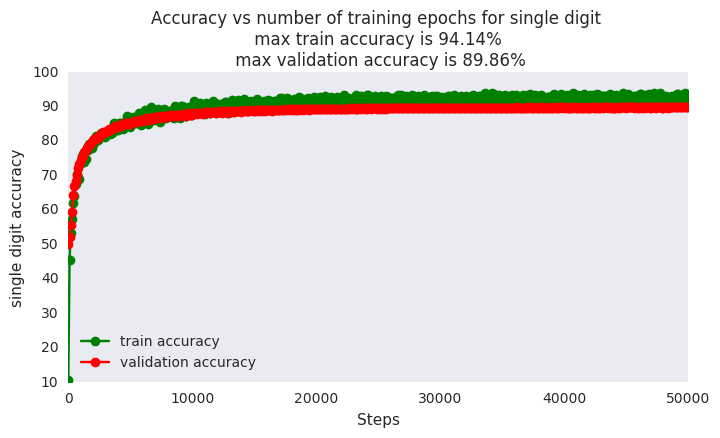

In [578]:
plot_train_valid(train_accuracy_s_m7, valid_accuracy_s_m7, 50000, 'single digit')

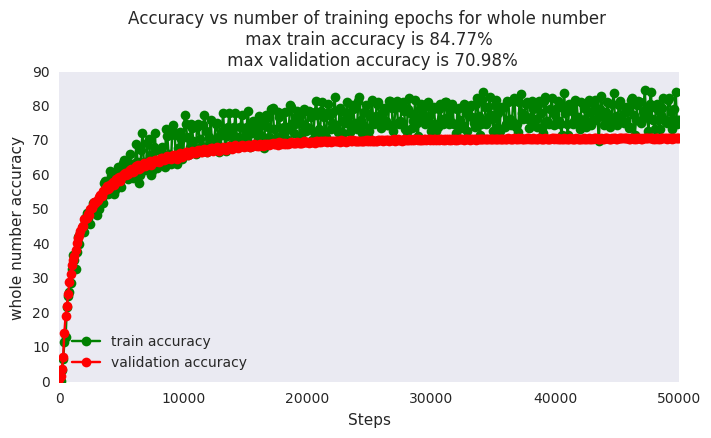

In [579]:
plot_train_valid(train_accuracy_n_m7, valid_accuracy_n_m7, 50000, 'whole number')

In [588]:
print("Training time for Model 7 is %d min" % int(training_time_f_m7/60))

Training time for Model 7 is 30 min


### Results:
#### Batch 128 models performances
#### Model 1
* **Best Minibatch single digit accuracy: 94.9%**
* **Best Minibatch whole number accuracy: 86.7%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.7%**

#### Model 2
* **Best Minibatch single digit accuracy: 92.4%**
* **Best Minibatch whole number accuracy: 75.8%**
* **Best Validation single digit accuracy: 88.0%**
* **Best Validation whole number accuracy: 66.9%**
* **Best Test single digit accuracy: 88.4%**
* **Best Test whole number accuracy: 68.3%**

#### Model 3
* **Best Minibatch single digit accuracy: 96.1%**
* **Best Minibatch whole number accuracy: 87.5%**
* **Best Validation single digit accuracy: 89.7%**
* **Best Validation whole number accuracy: 70.2%**
* **Best Test single digit accuracy: 89.9%**
* **Best Test whole number accuracy: 71.7%**


#### Model 4
* **Best Minibatch single digit accuracy: 94.5%**
* **Best Minibatch whole number accuracy: 82.8%**
* **Best Validation single digit accuracy: 90.0%**
* **Best Validation whole number accuracy: 71.4%**
* **Best Test single digit accuracy: 90.0%**
* **Best Test whole number accuracy: 71.5%**

#### Batch 256 models performances

#### Model 5
* **Best Minibatch single digit accuracy: 95.0%**
* **Best Minibatch whole number accuracy: 85.5%**
* **Best Validation single digit accuracy: 90.1%**
* **Best Validation whole number accuracy: 71.8%**
* **Best Test single digit accuracy: 90.8%**
* **Best Test whole number accuracy: 73.5%**

#### Model 6
* **Best Minibatch single digit accuracy: 93.8%**
* **Best Minibatch whole number accuracy: 84.0%**
* **Best Validation single digit accuracy: 90.3%**
* **Best Validation whole number accuracy: 72.2%**
* **Best Test single digit accuracy: 90.7%**
* **Best Test whole number accuracy: 74.1%**

#### Model 7

* **Best Minibatch single digit accuracy: 94.1%**
* **Best Minibatch whole number accuracy: 84.8%**
* **Best Validation single digit accuracy: 89.9%**
* **Best Validation whole number accuracy: 71.0%**
* **Best Test single digit accuracy: 90.4%**
* **Best Test whole number accuracy: 72.6%**

#### Best performance achieved using Model 6
**Try batch 512 on Model 6 with 100000 epochs for training as the Final Model for the project**

In [582]:
# image_size = 32
# num_channels = 1 # grayscale
# num_digits = train_labels.shape[1] - 1 # from earlier defined labels
# num_labels = 11 # per one digit

batch_size = 512
patch_size = 5
depth = [8, 16, 32, 64]
num_hidden = 1024
beta = 0.005 # L2 regularization constant for all layers
l_rate = 0.95 # learning rate decay 
num_steps = 100001

#########################################

graph = tf.Graph()

with graph.as_default():

    with tf.device('/gpu:1'):
    #with tf.device('/cpu:0'):
        # helper functions

        def layer_weights(dimentions):
            """
            this function return tf.Variable with truncated_normal(dimensions, stddev=0.1)
            """ 
            return tf.Variable(tf.truncated_normal(dimentions, stddev=0.1))
        def layer_biases(value, dimentions):
            """
            this function return  tf.Variable(tf.constant(value, shape=dimentions))
            """
            return tf.Variable(tf.constant(value, shape=dimentions))

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_digits))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # conv layers
        l1_w = layer_weights([patch_size, patch_size, num_channels, depth[0]])
        l1_b = layer_biases(0., [depth[0]])

        l2_w = layer_weights([patch_size, patch_size, depth[0], depth[1]])
        l2_b = layer_biases(1.0, [depth[1]])

        l3_w = layer_weights([patch_size, patch_size, depth[1], depth[2]])
        l3_b = layer_biases(1.0, [depth[2]])

        l3b_w = layer_weights([patch_size, patch_size, depth[2], depth[3]])
        l3b_b = layer_biases(1.0, [depth[3]])

        # fully connected flat layer
        l4_w = layer_weights([image_size // 16 * image_size // 16 * depth[3], num_hidden])
        l4_b = layer_biases(1.0, [num_hidden])

        # locally connected digit layers
        l_d_w = [layer_weights([num_hidden, num_labels]) for _ in range(num_digits)]
        l_d_b = [layer_biases(1.0, [num_labels]) for _ in range(num_digits)]

        # Model.
        def model(data, train = True):
          print('data', data.get_shape().as_list())

          conv = tf.nn.conv2d(data, l1_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l1_b)
          print('hidden conv1', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 1', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l2_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l2_b)
          print('hidden conv2', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 2', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3_b)
          print('hidden conv3', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 3', pool.get_shape().as_list())

          conv = tf.nn.conv2d(pool, l3b_w, [1, 1, 1, 1], padding='SAME')
          hidden = tf.nn.relu(conv + l3b_b)
          print('hidden conv4', hidden.get_shape().as_list())

          pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
          print('pool 4', pool.get_shape().as_list())

          shape = pool.get_shape().as_list()
          print("shape before flatten", shape)
          reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
          print("reshape_pool", reshape.get_shape().as_list())

          hidden = tf.nn.relu(tf.matmul(reshape, l4_w) + l4_b)
          if train:
              hidden = tf.nn.dropout(hidden, 0.75) # 75% dropout
          print('hidden fuc1', hidden.get_shape().as_list())

          final = []
          for idx in range(num_digits):
                final.append(tf.matmul(hidden, l_d_w[idx]) + l_d_b[idx])
                print("output layer for digit", idx+1, final[idx].get_shape().as_list())
          return final

        # Training computation.
        print("====================================")
        print("Train ConvNet")
        logits = model(tf_train_dataset)

        reg_hidden = beta * (tf.nn.l2_loss(l1_w) + tf.nn.l2_loss(l2_w) + tf.nn.l2_loss(l3_w)
                             + tf.nn.l2_loss(l3b_w) + tf.nn.l2_loss(l4_w))

        loss_digit = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[idx], 
                      tf_train_labels[:, idx])) + reg_hidden + 
                      beta * tf.nn.l2_loss(l_d_w[idx]) for idx in range(num_digits)]

        loss_final = tf.add_n(loss_digit)

        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(0.01, global_step, 1000, l_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_final, global_step=global_step) 

        # Predictions for the training, validation, and test data.
        def predictions_tf(logits_tmp, num_digits=num_digits, num_labels=num_labels):
            """
            predicting labels base on the current model
            """
            predictions_tmp = [tf.nn.softmax(logits_tmp[digit_idx]) for digit_idx in range(num_digits)]
            predictions = tf.pack(predictions_tmp)
            shape = predictions.get_shape().as_list()
            return predictions

        train_prediction = predictions_tf(logits)
        print("Train predictions shape", train_prediction.get_shape().as_list())
        print("====================================")
        print("Valid ConvNet")
        valid_prediction = predictions_tf(model(tf_valid_dataset, False))
        print("Valid predictions shape", valid_prediction.get_shape().as_list())
        print("====================================")
        print("Test ConvNet")
        test_prediction = predictions_tf(model(tf_test_dataset, False))
        print("Test predictions shape", test_prediction.get_shape().as_list())

# prepare dictionaries to save accuracies for every 100 steps
train_accuracy_s_m8 = {}
valid_accuracy_s_m8 = {}
test_accuracy_s_m8 = {}
train_accuracy_n_m8 = {}
valid_accuracy_n_m8 = {}
test_accuracy_n_m8 = {}

start = time.time()

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True)) as session:
    if sys.version_info.major == 2:
        print("Initializing variables")
        tf.initialize_all_variables().run()
    elif sys.version_info.major == 3: 
        print("Initializing variables") 
        tf.global_variables_initializer().run()
    else:
        print("I can't run it on this version of python")

    print("====================================")
    print("Initialized with batch size = %d, regularizaton beta = %f, and learning rate decay rate %.2f" % (batch_size, beta, l_rate))

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels_n.shape[0] - batch_size)
        batch_data = train_dataset_n[offset:(offset + batch_size), :, :, :]

        batch_labels = train_labels_n[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss_final, train_prediction], feed_dict=feed_dict)
        end = time.time()
        if (step % 100 == 0):
          train_accuracy_s_m8[step] = accuracy_single(predictions, batch_labels)    
          valid_accuracy_s_m8[step] = accuracy_single(valid_prediction.eval(), valid_labels)
          train_accuracy_n_m8[step] = accuracy_number(predictions, batch_labels)    
          valid_accuracy_n_m8[step] = accuracy_number(valid_prediction.eval(), valid_labels)
          test_predictions_final_m8 = test_prediction.eval()
          test_accuracy_s_m8[step] = accuracy_single(test_predictions_final_m8, test_labels)
          test_accuracy_n_m8[step] = accuracy_number(test_predictions_final_m8, test_labels)
          if (step % 1000 == 0):
              print("Learning rate: %f" % learning_rate.eval())
              print('Minibatch loss at step %d: %f' % (step, l))

              print('Minibatch single digit accuracy: %.1f%%' % train_accuracy_s_m8[step])
              print('Minibatch whole number accuracy: %.1f%%' % train_accuracy_n_m8[step])

              print('Validation single digit accuracy: %.1f%%' % valid_accuracy_s_m8[step])  
              print('Validation whole number accuracy: %.1f%%' % valid_accuracy_n_m8[step])

    print('Best Minibatch single digit accuracy: %.1f%%' % max(train_accuracy_s_m8.values()))
    print('Best Minibatch whole number accuracy: %.1f%%' % max(train_accuracy_n_m8.values()))
    print('Best Validation single digit accuracy: %.1f%%' % max(valid_accuracy_s_m8.values()))  
    print('Best Validation whole number accuracy: %.1f%%' % max(valid_accuracy_n_m8.values()))
    print('Best Test single digit accuracy: %.1f%%' % max(test_accuracy_s_m8.values()))
    print('Best Test whole number accuracy: %.1f%%' % max(test_accuracy_n_m8.values()))
    
training_time_f_m8 = end - start
print("Total training time is %f" % training_time_f_m8)

Train ConvNet
data [512, 32, 32, 1]
hidden conv1 [512, 32, 32, 8]
pool 1 [512, 16, 16, 8]
hidden conv2 [512, 16, 16, 16]
pool 2 [512, 8, 8, 16]
hidden conv3 [512, 8, 8, 32]
pool 3 [512, 4, 4, 32]
hidden conv4 [512, 4, 4, 64]
pool 4 [512, 2, 2, 64]
shape before flatten [512, 2, 2, 64]
reshape_pool [512, 256]
hidden fuc1 [512, 1024]
output layer for digit 1 [512, 11]
output layer for digit 2 [512, 11]
output layer for digit 3 [512, 11]
output layer for digit 4 [512, 11]
Train predictions shape [4, 512, 11]
Valid ConvNet
data [6968, 32, 32, 1]
hidden conv1 [6968, 32, 32, 8]
pool 1 [6968, 16, 16, 8]
hidden conv2 [6968, 16, 16, 16]
pool 2 [6968, 8, 8, 16]
hidden conv3 [6968, 8, 8, 32]
pool 3 [6968, 4, 4, 32]
hidden conv4 [6968, 4, 4, 64]
pool 4 [6968, 2, 2, 64]
shape before flatten [6968, 2, 2, 64]
reshape_pool [6968, 256]
hidden fuc1 [6968, 1024]
output layer for digit 1 [6968, 11]
output layer for digit 2 [6968, 11]
output layer for digit 3 [6968, 11]
output layer for digit 4 [6968, 11]
V

In [606]:
sns.set_style({'axes.grid' : True}) 

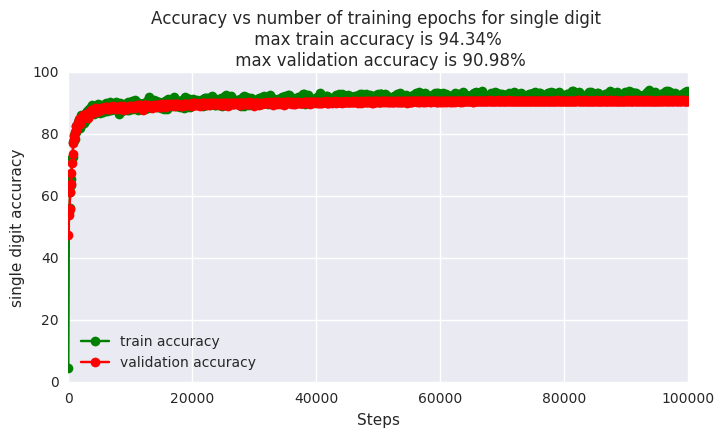

In [607]:
plot_train_valid(train_accuracy_s_m8, valid_accuracy_s_m8, 1000000, 'single digit')

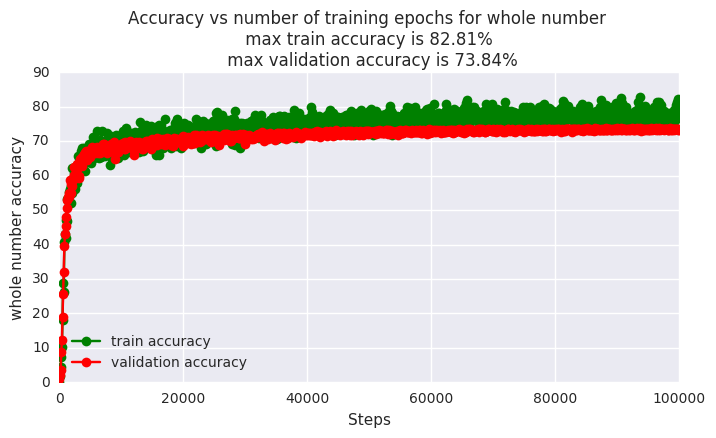

In [608]:
plot_train_valid(train_accuracy_n_m8, valid_accuracy_n_m8, 1000000, 'whole number')

In [589]:
print("Training time for FINAL Model is %d min" % int(training_time_f_m8/60))

Training time for FINAL Model is 77 min


In [609]:
sns.set_style({'axes.grid' : False}) 

### Final Results:

#### Final Model (the best out of all tested and tuned models):  
* input grayscale converted image natural scene number images from SVHN from Google images datasets rescaled to 32x32 pixels
* 4 convolutional networks layers with depth of 8, 16, 32, and 64, one fully connected layer (size 1024) and 4 parrallel digit reconition layes (size of 11)
* traing batch size is 512
* patch size for all conv leayers is 5
* beta - L2 regualrization constant (for all layers) = 0.005
* starting learning rate = 0.01, exponential learning rate decay rate = 0.95 in every 1000 steps
* number of epochs=100000
* training time 77 min

#### Final Model performance:
* **Best Minibatch single digit accuracy: 94.3%**
* **Best Minibatch whole number accuracy: 82.8%**
* **Best overall Validation single digit accuracy: 91.0%**
* **Best overall Validation whole number accuracy: 73.8%**
* **Best overall Test single digit accuracy: 91.2%**
* **Best overall Test whole number accuracy: 74.8%**


Properly predicted numbers examples


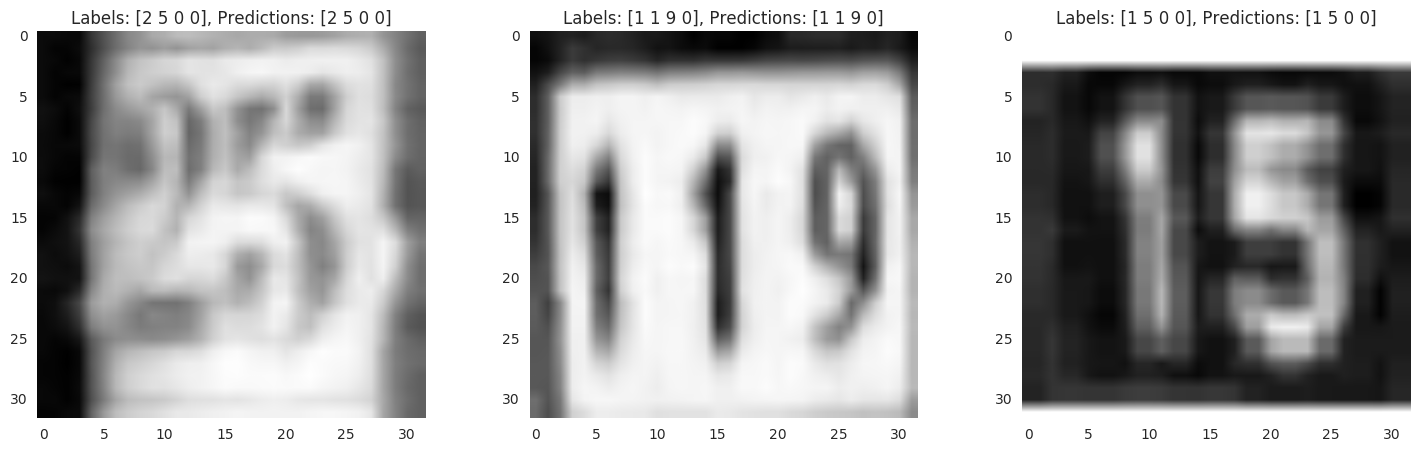

In [591]:
print("Properly predicted numbers examples")
model_final_image_idx_good_1 = image_show_ds(test_dataset, test_labels, test_predictions_final_m8, True)

Properly predicted numbers examples


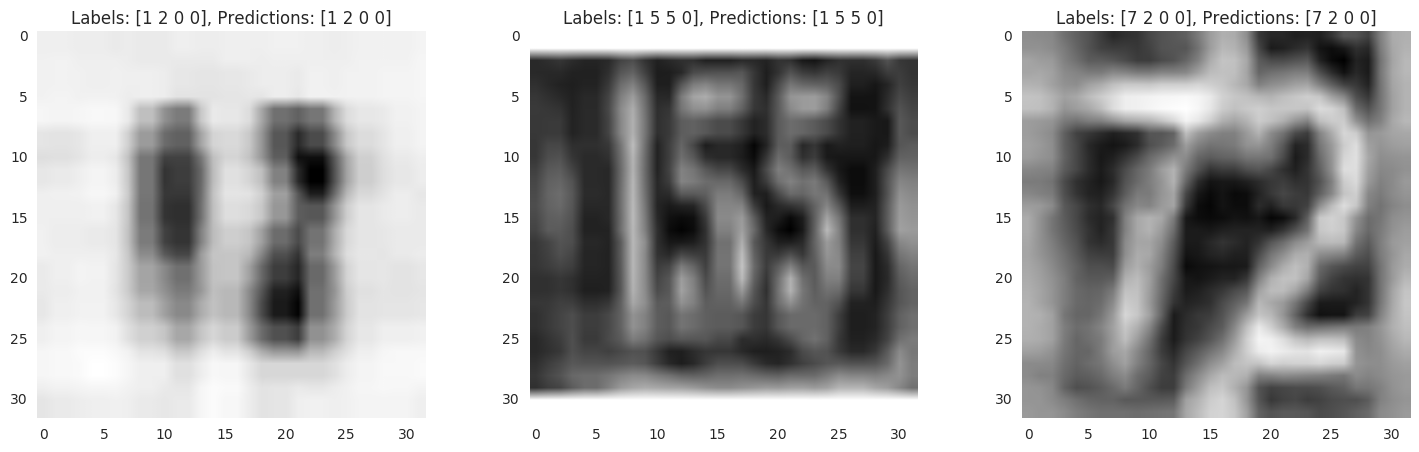

In [592]:
print("Properly predicted numbers examples")
model_final_image_idx_good_2 = image_show_ds(test_dataset, test_labels, test_predictions_final_m8, True)

Properly predicted numbers examples


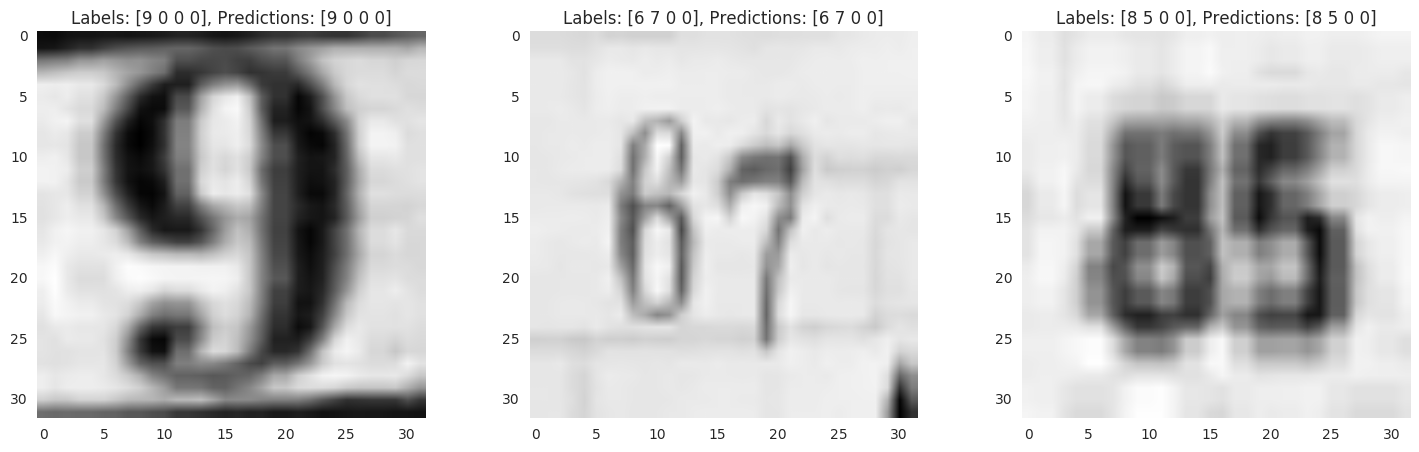

In [593]:
print("Properly predicted numbers examples")
model_final_image_idx_good_3 = image_show_ds(test_dataset, test_labels, test_predictions_final_m8, True)

Falsely predicted numbers examples


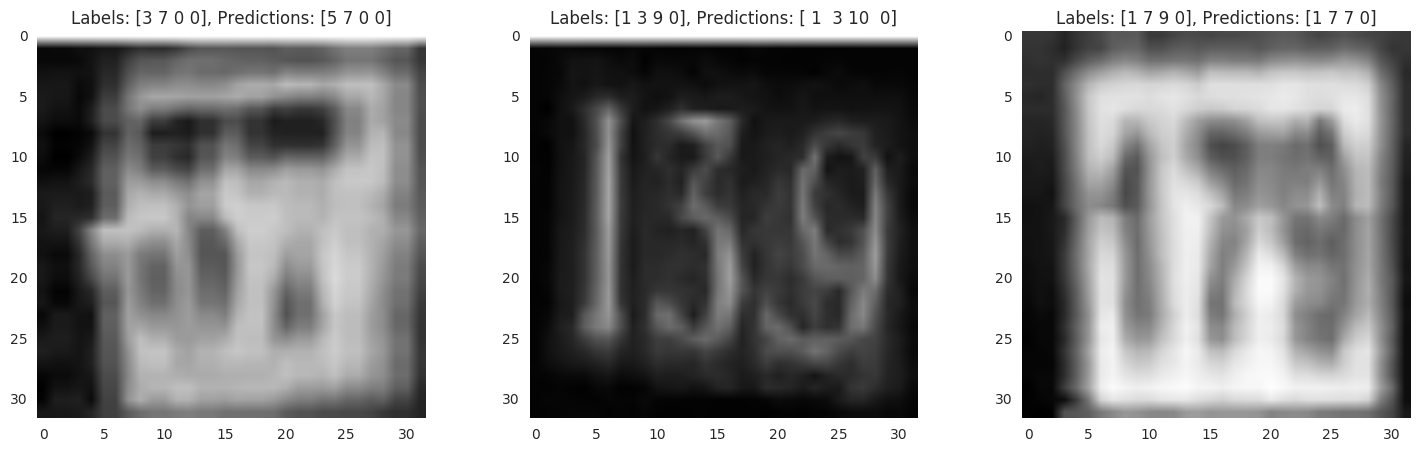

In [601]:
print("Falsely predicted numbers examples")
model_final_image_idx_bad_1 = image_show_ds(test_dataset, test_labels, test_predictions_final_m8,False)

Falsely predicted numbers examples


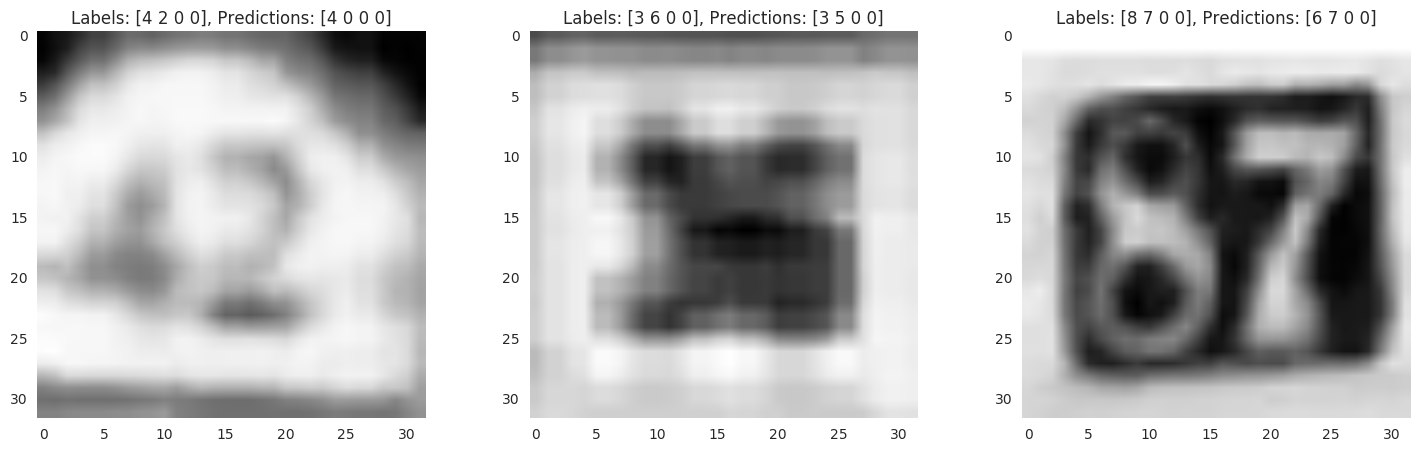

In [603]:
print("Falsely predicted numbers examples")
model_final_image_idx_bad_2 = image_show_ds(test_dataset, test_labels, test_predictions_final_m8,False)

Falsely predicted numbers examples


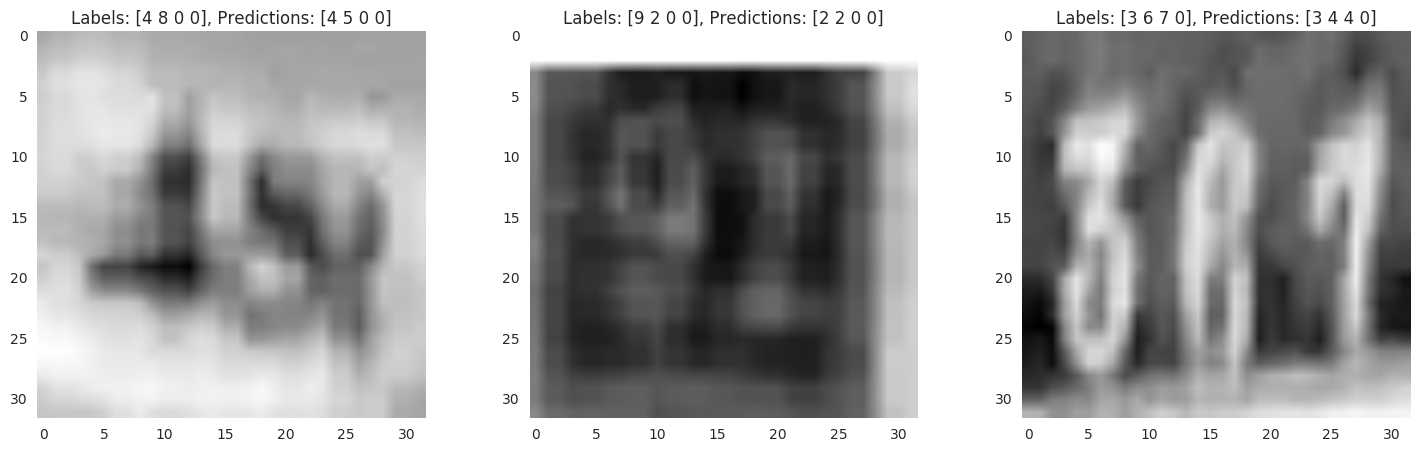

In [605]:
print("Falsely predicted numbers examples")
model_final_image_idx_bad_3 = image_show_ds(test_dataset, test_labels, test_predictions_final_m8,False)

#### Most of falsely identified numbers are quite hard numbers for recognition. It looks like the training set could be increased to get a more training examples, and/or the input images needed to be train in RGB, not the grey scale converted images, thus more image features will be picked up by model.